# Final Project Submission

Please fill out:
* Student name: **Brian Bentson**
* Student pace: self paced / part time / full time: **Full Time**
* Scheduled project review date/time: 
* Instructor name: **James Irving**
* Blog post URL:
* Video of 5-min Non-Technical Presentation:

# Table of Contents

*Click to jump to matching Markdown Header.*<br><br>
 
- **[INTRODUCTION](#Introduction)<br>**
- **[OBTAIN](#Obtain)**<br>
- **[SCRUB](#Scrub)**<br>
- **[EXPLORE](#Explore)**<br>
- **[MODEL](#Model)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
___

# Introduction

## Business Statement

One of the primary roles of a realtor is to provide their clients with a good initial estimate for a listing price. The listing price can't be too high, or else it may scare off potential buyers, and the price cannot be too low because then the home seller will sacrifice potential profit. Therefore, if a model can be built which predicts the appropriate listing price, a home seller can be confident that they will sell their house at a favorable price.

## Analysis Methodology

I will be analyzing historic home sales from King County, Washington in order to see which factors affect home price and how a model can be built to predict good estimates for home listing prices.

# Obtain

## Import Packages

In [1105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
plt.style.use('fivethirtyeight')

import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
import statsmodels.stats.api as sms
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [1106]:
pd.set_option("display.max_columns", 30)
pd.options.display.float_format = '{:,}'.format

## Global Functions

In [1107]:
#function to look at plots and stats of column with or without outliers
def get_plots(df, x_col, y_col='price', outlier='std'):
    
    """This function takes in a dataframe and a column, removes outliers using
       standard deviations or iqr and produces a histogram, scatter plot and
       boxplot of the values with descriptive statistics"""
    
    #create outlier variables
    col_mean = df[x_col].mean()
    col_std = df[x_col].std()
    upper_thresh_std = col_mean + 3*col_std
    lower_thresh_std = col_mean - 3*col_std
    q25 = df[x_col].quantile(0.25)
    q75 = df[x_col].quantile(0.75)
    iqr = q75-q25
    upper_thresh_iqr = q75 + 1.5*iqr
    lower_thresh_iqr = q25 - 1.5*iqr
    #create new dataframe with outliers removed
    std_df = df.loc[(df[x_col] > lower_thresh_std) & (df[x_col] < upper_thresh_std)]
    
    idx_iqr_outliers = (df[x_col] > lower_thresh_iqr) & (df[x_col] < upper_thresh_iqr)
    iqr_df = df.loc[idx_iqr_outliers]
   
    #plot a histogram, scatterplot and boxplot
    if outlier == 'std':
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10));
        histogram = std_df[x_col].hist(ax=ax[0,0]);
        ax[0,0].set_title(f'Distribution of {x_col}');

        scatter = std_df.plot(kind='scatter', x=x_col, y=y_col,ax=ax[0,1]);
        ax[0,1].set_title(f'{y_col} vs {x_col}');

        boxplot = std_df.boxplot(column=x_col, ax=ax[1,0]);
        ax[1,0].set_title(f'Boxplot of {x_col}');
        
        sm.graphics.qqplot(std_df[x_col], dist=stats.norm, line='45', fit=True, ax=ax[1,1])
        ax[1,1].set_title(f'QQ plot of {x_col}');
        
        rows_removed = len(df) - len(std_df)
        print(f'The number of rows removed is {rows_removed}')
        desc_stats = std_df[x_col].describe()
        plt.tight_layout()
        
    elif outlier == 'iqr':
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10));
        histogram = iqr_df[x_col].hist(ax=ax[0,0]);
        ax[0,0].set_title(f'Distribution of {x_col}');

        scatter = iqr_df.plot(kind='scatter', x=x_col, y=y_col,ax=ax[0,1]);
        ax[0,1].set_title(f'{y_col} vs {x_col}');

        boxplot = iqr_df.boxplot(column=x_col, ax=ax[1,0]);
        ax[1,0].set_title(f'Boxplot of {x_col}');
        
        sm.graphics.qqplot(iqr_df[x_col], dist=stats.norm, line='45', fit=True, ax=ax[1,1])
        ax[1,1].set_title(f'QQ plot of {x_col}');
        
        rows_removed = len(df) - len(iqr_df)
        print(f'The number of rows removed is {rows_removed}')
        desc_stats = df[x_col].describe()
        plt.tight_layout()
    elif outlier == 'none':
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10));
        histogram = df[x_col].hist(ax=ax[0,0]);
        ax[0,0].set_title(f'Distribution of {x_col}');

        scatter = df.plot(kind='scatter', x=x_col, y=y_col,ax=ax[0,1]);
        ax[0,1].set_title(f'{y_col} vs {x_col}');

        boxplot = df.boxplot(column=x_col, ax=ax[1,0]);
        ax[1,0].set_title(f'Boxplot of {x_col}');

        sm.graphics.qqplot(df[x_col], dist=stats.norm, line='45', fit=True, ax=ax[1,1])
        ax[1,1].set_title(f'QQ plot of {x_col}');
        
        desc_stats = df[x_col].describe()
        plt.tight_layout()
    print(desc_stats)
    plt.show()
    return idx_iqr_outliers
#     return histogram, scatter, boxplot, desc_stats, idx_iqr_outliers

In [1108]:
#function to preprocess and create a new model
def fit_new_model(df, x_cols=None, y_col=None, norm=False):
    '''This function takes in a dataframe, a list of independent and dependent
       variables and whether or not you want to normalize the columns. The 
       output is a multiple linear regression model with checks for 
       multicollinearity, normality and homoscedasticity.'''
         
    #step 1: normalize columns
    if norm == True:
        for col in x_cols:
            df[col] = (df[col] - df[col].mean())/df[col].std()
        #display the normalized df
        display(df.head())
        print('\n')
    else:
        #display the df
        display(df.head())
        print('\n')
    
    #step 2: create model
    
    #set up model parameters
    x_cols = x_cols
    outcome = y_col
    predictors = '+'.join(x_cols)
    formula = outcome + '~' + predictors
    #fit the model
    model = ols(formula=formula, data=df).fit()
    print(model.summary())
    print('\n')
    
    #step 3: check multicollinearity
    print('VIF Multicollinearity Test Results')
    print('======================================================================================================')
    #run VIF test
    X = df[x_cols]
    vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    display(list(zip(x_cols, vif)))
    print('\n')
    
    #step 4: check normality
    print('Normality Test Results')
    print('======================================================================================================')
    #plot qqplot
    fig, ax = plt.subplots(figsize=(15,10))
    sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True, ax=ax);
    ax.set_title('QQPlot for Model Residuals')
    plt.show()
    print('\n')
    
    #step 5: check homoscedasticity
    print('Homoscedasticity Test Results')
    print('======================================================================================================')
    #scatter plot
    fig, ax = plt.subplots(figsize=(15,10))
    plt.scatter(model.predict(df[x_cols]), model.resid)
    plt.plot(model.predict(df[x_cols]), [0 for i in range(len(df))])
    plt.show()
    return

## Import Data into Pandas

I will be importing a csv dataset which provides me with the information necessary to begin the analysis.

In [1109]:
#import the dataset from local csv
df_original = pd.read_csv('Data/kc_house_data.csv')
df_original

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,"221,900.0",3,1.0,1180,5650,1.0,nan,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,"538,000.0",3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,"1,991.0",98125,47.721000000000004,-122.319,1690,7639
2,5631500400,2/25/2015,"180,000.0",2,1.0,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,nan,98028,47.7379,-122.23299999999999,2720,8062
3,2487200875,12/9/2014,"604,000.0",4,3.0,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.39299999999999,1360,5000
4,1954400510,2/18/2015,"510,000.0",3,2.0,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,"360,000.0",3,2.5,1530,1131,3.0,0.0,0.0,3,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,"400,000.0",4,2.5,2310,5813,2.0,0.0,0.0,3,8,2310,0.0,2014,0.0,98146,47.5107,-122.36200000000001,1830,7200
21594,1523300141,6/23/2014,"402,101.0",2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0.0,2009,0.0,98144,47.5944,-122.29899999999999,1020,2007
21595,291310100,1/16/2015,"400,000.0",3,2.5,1600,2388,2.0,nan,0.0,3,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


## Data Schema

**Taken from https://rstudio-pubs-static.s3.amazonaws.com/155304_cc51f448116744069664b35e7762999f.html**

id - Unique ID for each home sold 

date - Date of the home sale 

price - Price of each home sold 

bedrooms - Number of bedrooms 

bathrooms - Number of bathrooms, where .5 accounts for a room with a toilet but no shower 

sqft_living - Square footage of the apartments interior living space 

sqft_lot - Square footage of the land space 

floors - Number of floors 

waterfront - A dummy variable for whether the apartment was overlooking the waterfront or not 

view - An index from 0 to 4 of how good the view of the property was 

condition - An index from 1 to 5 on the condition of the apartment, 

grade - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design. 

sqft_above - The square footage of the interior housing space that is above ground level 

sqft_basement - The square footage of the interior housing space that is below ground level 

yr_built - The year the house was initially built 

yr_renovated - The year of the house’s last renovation 

zipcode - What zipcode area the house is in 

lat - Lattitude 

long - Longitude 

sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors 

sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors 

## Investigate Data

I will preliminarily investigate the data to identify any glaring issues to fix later.

In [1110]:
#column names
df_original.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [1111]:
#view df info to inspect data types
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

> **Observations on Data**
> - `waterfront` values should be updated to categorical
> - `yr_renovated` values should be updated to categorical
> - `sqft_basement` data type should be changed to integer

In [1112]:
#check for null values
df_original.isna().sum()/len(df_original)*100

id                              0.0
date                            0.0
price                           0.0
bedrooms                        0.0
bathrooms                       0.0
sqft_living                     0.0
sqft_lot                        0.0
floors                          0.0
waterfront        11.00152798999861
view            0.29170718155299347
condition                       0.0
grade                           0.0
sqft_above                      0.0
sqft_basement                   0.0
yr_built                        0.0
yr_renovated      17.78950780200954
zipcode                         0.0
lat                             0.0
long                            0.0
sqft_living15                   0.0
sqft_lot15                      0.0
dtype: float64

> **Observations on Data**
> - `waterfront` has 11% null values which may be dropped
> - `view` should be inspected for a potential column drop
> - `yr_renovated` has 18% null values which may be dropped
> - All other columns have 0 nulls

In [1113]:
#check numeric data
df_original.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,"21,597.0","21,597.0","21,597.0","21,597.0","21,597.0","21,597.0","21,597.0","19,221.0","21,534.0","21,597.0","21,597.0","21,597.0","21,597.0","17,755.0","21,597.0","21,597.0","21,597.0","21,597.0","21,597.0"
mean,"4,580,474,287.770987","540,296.5735055795",3.3731999814789093,2.1158262721674306,"2,080.3218502569803","15,099.408760475992",1.4940964022780943,0.007595858696217679,0.23386272870808952,3.4098254387183404,7.657915451220076,"1,788.5968421540028","1,970.9996758809093",83.6367783722895,"98,077.95184516368",47.56009299439737,-122.2139824975691,"1,986.6203176367087","12,758.283511598833"
std,"2,876,735,715.74778","367,368.1401013945",0.9262988945421479,0.7689842966527209,918.1061250800805,"41,412.636875502074",0.5396827909775457,0.08682484570054606,0.7656862011746727,0.6505456356725546,1.1731996637760254,827.7597611646754,29.375234132441644,399.9464138788162,53.51307235352816,0.13855176817307177,0.14072352882947373,685.2304719001586,"27,274.441950386343"
min,"1,000,102.0","78,000.0",1.0,0.5,370.0,520.0,1.0,0.0,0.0,1.0,3.0,370.0,"1,900.0",0.0,"98,001.0",47.1559,-122.51899999999999,399.0,651.0
25%,"2,123,049,175.0","322,000.0",3.0,1.75,"1,430.0","5,040.0",1.0,0.0,0.0,3.0,7.0,"1,190.0","1,951.0",0.0,"98,033.0",47.4711,-122.32799999999999,"1,490.0","5,100.0"
50%,"3,904,930,410.0","450,000.0",3.0,2.25,"1,910.0","7,618.0",1.5,0.0,0.0,3.0,7.0,"1,560.0","1,975.0",0.0,"98,065.0",47.5718,-122.23100000000001,"1,840.0","7,620.0"
75%,"7,308,900,490.0","645,000.0",4.0,2.5,"2,550.0","10,685.0",2.0,0.0,0.0,4.0,8.0,"2,210.0","1,997.0",0.0,"98,118.0",47.678000000000004,-122.125,"2,360.0","10,083.0"
max,"9,900,000,190.0","7,700,000.0",33.0,8.0,"13,540.0","1,651,359.0",3.5,1.0,4.0,5.0,13.0,"9,410.0","2,015.0","2,015.0","98,199.0",47.7776,-121.315,"6,210.0","871,200.0"


# Scrub

I will make a new dataframe which is a copy of the `df_original` dataframe to begin making changes. 

In [1114]:
#create a copy of the original dataframe
df_scrub = df_original.copy()
df_scrub

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,"221,900.0",3,1.0,1180,5650,1.0,nan,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,"538,000.0",3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,"1,991.0",98125,47.721000000000004,-122.319,1690,7639
2,5631500400,2/25/2015,"180,000.0",2,1.0,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,nan,98028,47.7379,-122.23299999999999,2720,8062
3,2487200875,12/9/2014,"604,000.0",4,3.0,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.39299999999999,1360,5000
4,1954400510,2/18/2015,"510,000.0",3,2.0,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,"360,000.0",3,2.5,1530,1131,3.0,0.0,0.0,3,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,"400,000.0",4,2.5,2310,5813,2.0,0.0,0.0,3,8,2310,0.0,2014,0.0,98146,47.5107,-122.36200000000001,1830,7200
21594,1523300141,6/23/2014,"402,101.0",2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0.0,2009,0.0,98144,47.5944,-122.29899999999999,1020,2007
21595,291310100,1/16/2015,"400,000.0",3,2.5,1600,2388,2.0,nan,0.0,3,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


## Feature Engineering

### Basement Column

In the dataset we have 3 related columns:
- `sqft_above`
- `sqft_basement`
- `sqft_living`

These columns are related in that `sqft_living` equals `sqft_above` plus `sqft_basement`. I do not think the square footage of the basement is as important as just knowing that a house has one. Therefore, I will create a new column which shows whether or not a house has a basement.

In [1115]:
#investigate values in sqft_basement
df_scrub['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
65.0          1
1990.0        1
415.0         1
2400.0        1
1770.0        1
Name: sqft_basement, Length: 304, dtype: int64

> **ACTION: '?' impedes the ability to create a new column. Will drop the 454 rows, which is 2% of the data**

In [1116]:
#drop rows with '?' value in sqft_basement column
df_scrub.drop(df_scrub.loc[df_scrub['sqft_basement'] == '?'].index,inplace=True)
print(f'The dataframe now has {len(df_scrub)} many rows.')

The dataframe now has 21143 many rows.


In [1117]:
#prove that these columns are related
df_scrub['sqft_basement'] = df_scrub['sqft_basement'].astype(float).astype(int)
sqft = df_scrub[['sqft_living', 'sqft_above', 'sqft_basement']]
df_scrub['sqft_basement'].dtype
(sqft['sqft_above'] + sqft['sqft_basement'] == sqft['sqft_living']).value_counts()

True    21143
dtype: int64

In [1118]:
#check the rows have been dropped
df_scrub.loc[df_original['sqft_basement'] == '?']['sqft_basement'].count()

0

> **ACTIONS**
> - Will now create new column named `basement` which represents whether or not a house has a basement.

In [1119]:
#create new column for basement
df_scrub['basement'] = np.where(df_scrub['sqft_basement'] > 0, 1,0)
df_scrub

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,basement
0,7129300520,10/13/2014,"221,900.0",3,1.0,1180,5650,1.0,nan,0.0,3,7,1180,0,1955,0.0,98178,47.5112,-122.257,1340,5650,0
1,6414100192,12/9/2014,"538,000.0",3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400,1951,"1,991.0",98125,47.721000000000004,-122.319,1690,7639,1
2,5631500400,2/25/2015,"180,000.0",2,1.0,770,10000,1.0,0.0,0.0,3,6,770,0,1933,nan,98028,47.7379,-122.23299999999999,2720,8062,0
3,2487200875,12/9/2014,"604,000.0",4,3.0,1960,5000,1.0,0.0,0.0,5,7,1050,910,1965,0.0,98136,47.5208,-122.39299999999999,1360,5000,1
4,1954400510,2/18/2015,"510,000.0",3,2.0,1680,8080,1.0,0.0,0.0,3,8,1680,0,1987,0.0,98074,47.6168,-122.045,1800,7503,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,"360,000.0",3,2.5,1530,1131,3.0,0.0,0.0,3,8,1530,0,2009,0.0,98103,47.6993,-122.346,1530,1509,0
21593,6600060120,2/23/2015,"400,000.0",4,2.5,2310,5813,2.0,0.0,0.0,3,8,2310,0,2014,0.0,98146,47.5107,-122.36200000000001,1830,7200,0
21594,1523300141,6/23/2014,"402,101.0",2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0,2009,0.0,98144,47.5944,-122.29899999999999,1020,2007,0
21595,291310100,1/16/2015,"400,000.0",3,2.5,1600,2388,2.0,nan,0.0,3,8,1600,0,2004,0.0,98027,47.5345,-122.069,1410,1287,0


### Month Sold Column

I want to extract the month sold to investigate if sale timing has any affect on housing prices

In [1120]:
#create new month sold column
df_scrub['date'] = pd.to_datetime(df_scrub['date'])
df_scrub['month_sold'] = df_scrub['date'].dt.month
df_scrub.loc[:3,['date','month_sold']]

,date,month_sold
0,2014-10-13,10
1,2014-12-09,12
2,2015-02-25,2
3,2014-12-09,12


### Renovated Column

I want to reconfigure the `yr_renovated` column so that it is compatible with the model. I will drop null rows and create a new column which indicates whether or not a house has been renovated.

In [1121]:
#check values in yr_renovated column
df_scrub['yr_renovated'].value_counts(dropna=False).head(20)

0.0        16666
nan         3754
2,014.0       69
2,013.0       31
2,003.0       31
2,007.0       30
2,000.0       29
2,005.0       29
1,990.0       22
2,009.0       21
2,004.0       21
2,006.0       20
1,989.0       18
2,002.0       17
2,008.0       15
1,998.0       15
1,999.0       15
1,983.0       15
1,984.0       15
1,987.0       14
Name: yr_renovated, dtype: int64

> **ACTION: I will remove the 3,330 null rows**

In [1122]:
#remove null values from yr_renovated
df_scrub.dropna(subset=['yr_renovated'], inplace=True)
df_scrub['yr_renovated'].value_counts(dropna=False)

0.0        16666
2,014.0       69
2,003.0       31
2,013.0       31
2,007.0       30
           ...  
1,953.0        1
1,944.0        1
1,934.0        1
1,971.0        1
1,959.0        1
Name: yr_renovated, Length: 69, dtype: int64

> **ACTION: Create new `renovated` column which gives a 0 if false and 1 if true**

In [1123]:
#create new column based on yr_renovated
df_scrub['renovated'] = np.where(df_scrub['yr_renovated'] == 0, 0, 1)
df_scrub[['yr_renovated','renovated']]

,yr_renovated,renovated
0,0.0,0
1,"1,991.0",1
3,0.0,0
4,0.0,0
5,0.0,0
...,...,...
21592,0.0,0
21593,0.0,0
21594,0.0,0
21595,0.0,0


### Years Since Renovation Column (Not completed)

I want to understand if performing a renovation closer to the sale is more impactful for home value.

In [1124]:
#check data types of date and yr_renovated columns
# print(df_scrub['date'].dtype, df_scrub['yr_renovated'].dtype)

> **ACTION: Extract Year from `date` column, convert to int and then subtract from `yr_renovated` column**

In [1125]:
#extract the year of sale from the date column
df_scrub['yr_sold'] = df_scrub['date'].dt.year
df_scrub['yr_sold']

0        2014
1        2014
3        2014
4        2015
5        2014
         ... 
21592    2014
21593    2015
21594    2014
21595    2015
21596    2014
Name: yr_sold, Length: 17389, dtype: int64

> **ACTION: Create new column named `renovation_years` which describes the difference between the year sold and the renovation year.**

In [1126]:
#create the new column
# if df_scrub['renovated'] == 1:
#     print('yes')
# else:
#     print('no')

### Home Age Column

I want to create a column named `home_age` which represents the homes age which I believe will be more informative in a model.

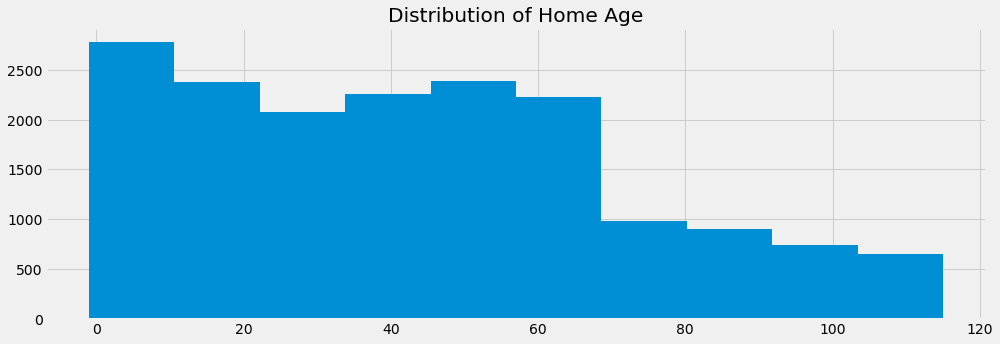

In [1127]:
#create new column
df_scrub['home_age'] = df_scrub['yr_sold'] - df_scrub['yr_built']
#plot distribution
fig, ax = plt.subplots(figsize=(15,5))
df_scrub['home_age'].hist(ax=ax);
ax.set_title('Distribution of Home Age');

## Change Data Types

In [1128]:
#check data types
df_scrub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17389 entries, 0 to 21596
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             17389 non-null  int64         
 1   date           17389 non-null  datetime64[ns]
 2   price          17389 non-null  float64       
 3   bedrooms       17389 non-null  int64         
 4   bathrooms      17389 non-null  float64       
 5   sqft_living    17389 non-null  int64         
 6   sqft_lot       17389 non-null  int64         
 7   floors         17389 non-null  float64       
 8   waterfront     15474 non-null  float64       
 9   view           17340 non-null  float64       
 10  condition      17389 non-null  int64         
 11  grade          17389 non-null  int64         
 12  sqft_above     17389 non-null  int64         
 13  sqft_basement  17389 non-null  int64         
 14  yr_built       17389 non-null  int64         
 15  yr_renovated   1738

## Null Values

In [1129]:
#check for null values
df_scrub.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       1915
view               49
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated        0
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
basement            0
month_sold          0
renovated           0
yr_sold             0
home_age            0
dtype: int64

### `waterfront` Column

In [1130]:
#view values in waterfront column
df_scrub['waterfront'].value_counts(dropna=False)

0.0    15357
nan     1915
1.0      117
Name: waterfront, dtype: int64

> **OBSERVATIONS:**
> - `waterfront` has 11% null values.

> **ACTION**
> - I will explore how I can fill the nulls in the `waterfront` values

In [1131]:
#correlation of waterfront
df_scrub.corr()['waterfront']

id              0.00025701287504176993
price               0.2822770948170352
bedrooms        -0.0010807514336662167
bathrooms          0.07002178441901094
sqft_living        0.11649875240644571
sqft_lot          0.025385694196076926
floors             0.01821976032702285
waterfront                         1.0
view               0.40725992880117945
condition         0.017090301729900097
grade              0.08593714755629313
sqft_above         0.07997648285568942
sqft_basement      0.09212792372004248
yr_built         -0.022434269901402182
yr_renovated       0.08326974566746399
zipcode           0.028560804093605768
lat              -0.014982528490386579
long              -0.04034577150059966
sqft_living15      0.09416738570266123
sqft_lot15         0.02917024013318345
basement           0.04268581043019616
month_sold        0.014599592882492693
renovated          0.08366555989807102
yr_sold          -0.009168044881655594
home_age          0.022286515506026887
Name: waterfront, dtype: 

> **OBSERVATIONS**
> - `waterfront` correlates most closely with `view` at a coefficient of 0.40

> **ACTIONS**
> - I will determine how i can utilize the `view` column to fill out the nulls in the `waterfall` column

In [1132]:
#number of waterfront properties in each view category
df_scrub.groupby('view')['waterfront'].sum()

view
0.0    0.0
1.0    1.0
2.0    6.0
3.0   10.0
4.0   99.0
Name: waterfront, dtype: float64

> **OBSERVATIONS**
> - It seems that most of the waterfront homes also have a view ranking of 3 or 4

In [1133]:
#there are 19 null values in waterfront with a view of 4
df_scrub.loc[(df_scrub['waterfront'].isna()) & (df_scrub['view'] == 4)].head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,basement,month_sold,renovated,yr_sold,home_age
582,2998800125,2014-07-01,"730,000.0",2,2.25,2130,4920,1.5,nan,4.0,4,7,1530,600,1941,0.0,98116,47.573,-122.40899999999999,2130,4920,1,7,0,2014,73
1732,913000340,2015-01-02,"252,000.0",1,1.0,680,1638,1.0,nan,4.0,1,6,680,0,1910,"1,992.0",98116,47.5832,-122.399,1010,3621,0,1,1,2015,105
2563,7856400240,2015-02-11,"1,650,000.0",4,3.0,3900,9750,1.0,nan,4.0,5,10,2520,1380,1972,0.0,98006,47.5605,-122.15799999999999,3410,9450,1,2,0,2015,43
3825,8550001515,2014-10-01,"429,592.0",2,2.75,1992,10946,1.5,nan,4.0,5,6,1288,704,1903,0.0,98070,47.3551,-122.475,1110,8328,1,10,0,2014,111
4422,7781600100,2014-09-05,"1,340,000.0",3,2.75,2730,38869,1.5,nan,4.0,3,9,1940,790,1963,"2,001.0",98146,47.4857,-122.361,2630,28188,1,9,1,2014,51


In [1134]:
#there are 54 null values in waterfront with a view of 3
df_scrub.loc[(df_scrub['waterfront'].isna()) & (df_scrub['view'] == 3)].head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,basement,month_sold,renovated,yr_sold,home_age
60,1516000055,2014-12-10,"650,000.0",3,2.25,2150,21235,1.0,nan,3.0,4,8,1590,560,1959,0.0,98166,47.4336,-122.339,2570,18900,1,12,0,2014,55
216,46100204,2015-02-21,"1,510,000.0",5,3.0,3300,33474,1.0,nan,3.0,3,9,1870,1430,1957,"1,991.0",98040,47.5673,-122.21,3836,20953,1,2,1,2015,58
527,3225079035,2014-06-18,"1,600,000.0",6,5.0,6050,230652,2.0,nan,3.0,3,11,6050,0,2001,0.0,98024,47.6033,-121.943,4210,233971,0,6,0,2014,13
707,4022907770,2014-10-14,"550,000.0",4,1.75,2480,14782,1.0,nan,3.0,3,8,1460,1020,1958,0.0,98155,47.7646,-122.271,2910,10800,1,10,0,2014,56
830,2061100570,2015-02-10,"595,000.0",3,1.75,1910,5753,1.0,nan,3.0,3,8,1110,800,1941,0.0,98115,47.6898,-122.32700000000001,1630,5580,1,2,0,2015,74


> **ACTIONS**
> - Fill in the null waterfront value when the view is 3 or 4

In [1135]:
#fill in null where view is 4
df_scrub.loc[(df_scrub['waterfront'].isna()) & (df_scrub['view'] == 4),['waterfront']] = 1

In [1136]:
#fill in null where view is 3
df_scrub.loc[(df_scrub['waterfront'].isna()) & (df_scrub['view'] == 3),['waterfront']] = 1

In [1137]:
#check the changes
df_scrub.loc[(df_scrub['waterfront'].isna()) & (df_scrub['view'] == 4)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,basement,month_sold,renovated,yr_sold,home_age


In [1138]:
#check the changes
df_scrub.loc[(df_scrub['waterfront'].isna()) & (df_scrub['view'] == 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,basement,month_sold,renovated,yr_sold,home_age


In [1139]:
#view values in waterfront column
df_scrub['waterfront'].value_counts(dropna=False)/len(df_scrub)

0.0      0.883144516648456
nan    0.10592903559721663
1.0   0.010926447754327448
Name: waterfront, dtype: float64

>**OBSERVATIONS**
> - The number of nulls in the `waterfront` column is still 10.5%

>**ACTIONS**
> - I will convert the rest of the nulls to zeros as they do not seem to have any other indicators of being a waterfront property

In [1140]:
#convert waterfront null values to 0
df_scrub.loc[df_scrub['waterfront'].isna(),['waterfront']] = 0

In [1141]:
#check waterfront values
df_scrub['waterfront'].value_counts(dropna=False)

0.0    17199
1.0      190
Name: waterfront, dtype: int64

In [1142]:
print(f'The dataframe now has {len(df_scrub)} many rows.')

The dataframe now has 17389 many rows.


### `view` Column

In [1143]:
#view the values of the view column
df_scrub['view'].value_counts(dropna=False)

0.0    15649
2.0      770
3.0      393
1.0      274
4.0      254
nan       49
Name: view, dtype: int64

> **ACTION:**
> - I will drop the 39 null values

In [1144]:
#drop rows
df_scrub.dropna(subset=['view'], inplace=True)
df_scrub['view'].isna().sum()

0

In [1145]:
#check the view column
df_scrub['view'].value_counts(dropna=False)

0.0    15649
2.0      770
3.0      393
1.0      274
4.0      254
Name: view, dtype: int64

In [1146]:
#recheck null values in dataframe
df_scrub.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
basement         0
month_sold       0
renovated        0
yr_sold          0
home_age         0
dtype: int64

## Duplicates

### Duplicates for `id`

In [1147]:
#check for duplicates
duplicate_id = df_scrub.loc[df_scrub.duplicated(subset='id', keep=False) == True].sort_values('id').head(50)
duplicate_id.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,basement,month_sold,renovated,yr_sold,home_age
2494,1000102,2014-09-16,"280,000.0",6,3.0,2400,9373,2.0,0.0,0.0,3,7,2400,0,1991,0.0,98002,47.3262,-122.214,2060,7316,0,9,0,2014,23
2495,1000102,2015-04-22,"300,000.0",6,3.0,2400,9373,2.0,0.0,0.0,3,7,2400,0,1991,0.0,98002,47.3262,-122.214,2060,7316,0,4,0,2015,24
11422,109200390,2014-10-20,"250,000.0",3,1.75,1480,3900,1.0,0.0,0.0,4,7,1480,0,1980,0.0,98023,47.2977,-122.367,1830,6956,0,10,0,2014,34
11421,109200390,2014-08-20,"245,000.0",3,1.75,1480,3900,1.0,0.0,0.0,4,7,1480,0,1980,0.0,98023,47.2977,-122.367,1830,6956,0,8,0,2014,34
7785,251300110,2014-07-31,"225,000.0",3,2.25,2510,12013,2.0,0.0,0.0,3,8,2510,0,1988,0.0,98003,47.3473,-122.314,1870,8017,0,7,0,2014,26


In [1148]:
#check duplicates
df_scrub.loc[df_scrub['id'] == 4139480200]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,basement,month_sold,renovated,yr_sold,home_age
313,4139480200,2014-06-18,"1,380,000.0",4,3.25,4290,12103,1.0,0.0,3.0,3,11,2690,1600,1997,0.0,98006,47.5503,-122.102,3860,11244,1,6,0,2014,17
314,4139480200,2014-12-09,"1,400,000.0",4,3.25,4290,12103,1.0,0.0,3.0,3,11,2690,1600,1997,0.0,98006,47.5503,-122.102,3860,11244,1,12,0,2014,17


> **OBSERVATOINS**
> - Duplicates in the `id` column seem to represent multiple sales of the same house. I will remove them because they aren't many and I am not sure how they will impact the model's prediction.

In [1149]:
#remove duplicates
df_scrub.drop(duplicate_id.index, inplace=True)

## Column Drop

In [1150]:
#look at columns
df_scrub.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'basement', 'month_sold',
       'renovated', 'yr_sold', 'home_age'],
      dtype='object')

### The `sqft_basement` Column

The `sqft_basement` column can be eliminated now that I have a column which represents whether or not a house has a basement.

In [1151]:
#drop the sqft_basement column
df_scrub.drop(columns='sqft_basement', inplace=True)
df_scrub.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'basement', 'month_sold', 'renovated',
       'yr_sold', 'home_age'],
      dtype='object')

### The `sqft_living15` and `sqft_lot15` Columns

The `sqft_living15` and `sqft_lot15` columns do not seem to be relevant for predicting home listing prices. I will remove these.

In [1152]:
#drop columns
df_scrub.drop(columns=['sqft_living15','sqft_lot15'], inplace=True)
df_scrub.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'basement', 'month_sold', 'renovated', 'yr_sold', 'home_age'],
      dtype='object')

### `yr_renovated` Column

In [1153]:
#drop the yr_renovated column
df_scrub.drop(columns='yr_renovated', inplace=True)

## Outlier Removal

In [1154]:
#column data
df_scrub.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'yr_built', 'zipcode', 'lat', 'long', 'basement',
       'month_sold', 'renovated', 'yr_sold', 'home_age'],
      dtype='object')

### `price` Column

count             17,290.0
mean    541,252.7264314633
std       368,713.27161303
min               80,000.0
25%              322,500.0
50%              450,000.0
75%              645,000.0
max            7,700,000.0
Name: price, dtype: float64


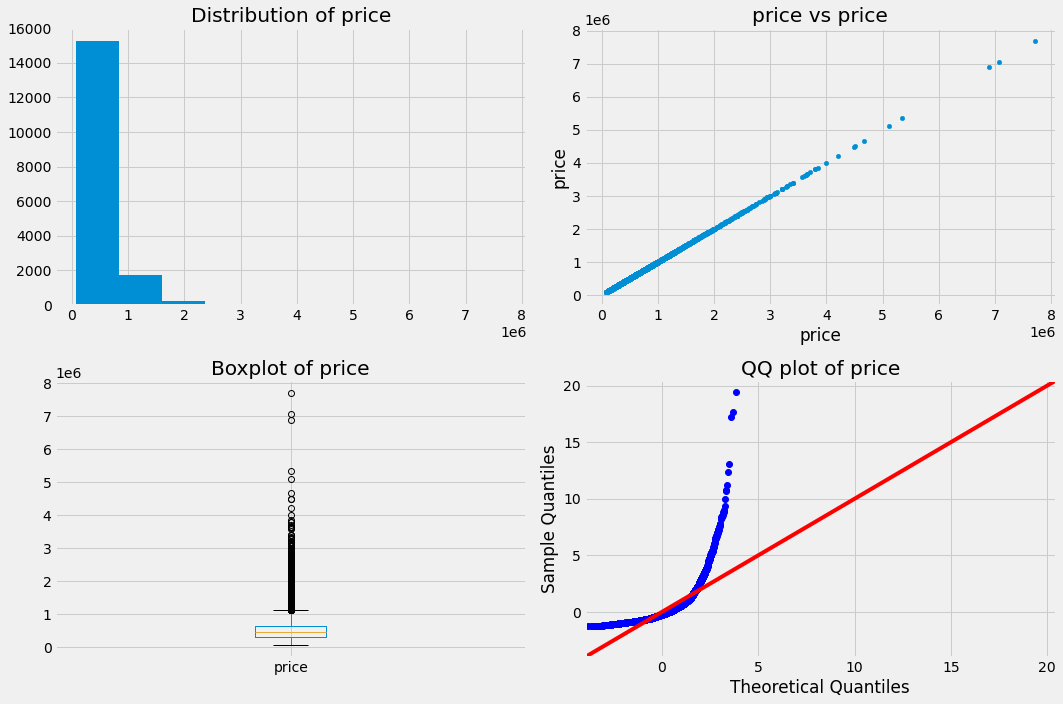

0         True
1         True
3         True
4         True
5        False
         ...  
21592     True
21593     True
21594     True
21595     True
21596     True
Name: price, Length: 17290, dtype: bool

In [1155]:
#look at plots
get_plots(df_scrub, 'price', outlier='none')

> **OBSERVATIONS**
> - Price has many outliers
> - Distribution is not normal

> **ACTIONS**
> - I will leave the outliers in the dataset for now

### `sqft_living` Column

count            17,290.0
mean    2,086.02024291498
std     918.2987286129909
min                 370.0
25%               1,430.0
50%               1,920.0
75%               2,550.0
max              13,540.0
Name: sqft_living, dtype: float64


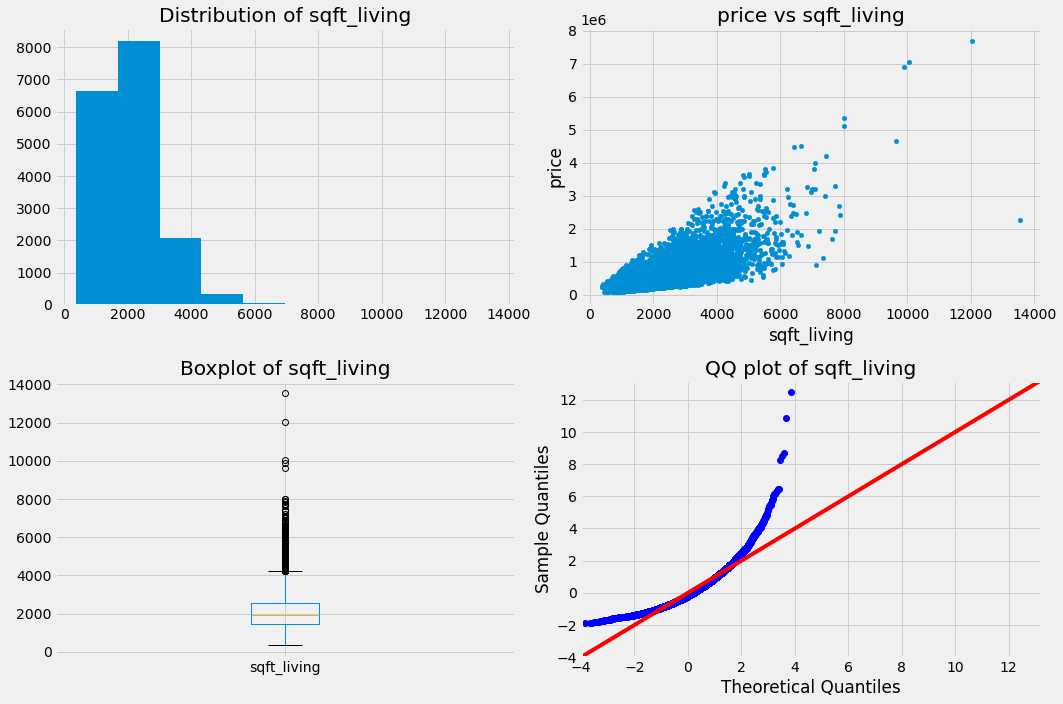

In [1156]:
#look at plots
sqft_living_iqr = get_plots(df_scrub,'sqft_living', outlier='none')

> **Observations:**
> - Many outliers
> - Distribution is not normal
> - Linear relationship with `price`

> **ACTION:**
> - I will remove the outliers based on iqr as the distribution is not normal

In [1157]:
#remove outliers based off iqr
q25 = df_scrub['sqft_living'].quantile(0.25)
q75 = df_scrub['sqft_living'].quantile(0.75)
iqr = q75-q25
upper_thresh = q75 + 1.5*iqr
lower_thresh = q25 - 1.5*iqr
df_scrub = df_scrub.loc[sqft_living_iqr]
print(f'The number of rows is now {len(df_scrub)}')

The number of rows is now 16804


count              16,804.0
mean    2,001.4403118305165
std       765.1011508687525
min                   370.0
25%                 1,410.0
50%                 1,890.0
75%                 2,490.0
max                 4,225.0
Name: sqft_living, dtype: float64


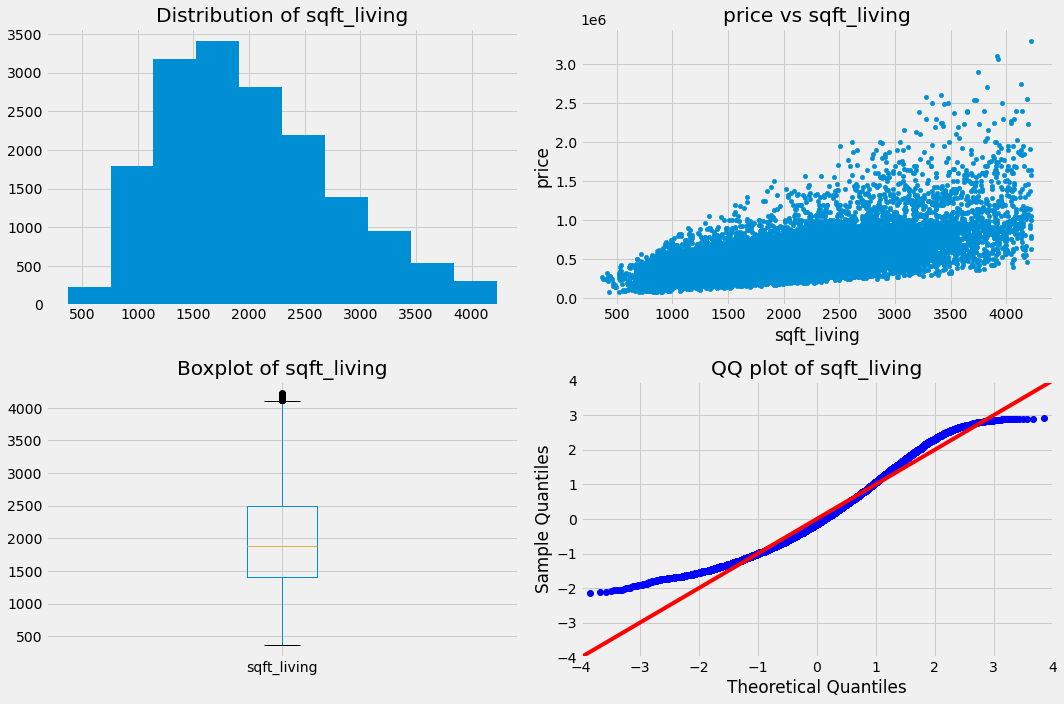

In [1158]:
#re-look at plots
sqft_living_iqr = get_plots(df_scrub,'sqft_living', outlier='none')

### `bedrooms` Column

count             16,804.0
mean     3.344917876696025
std     0.9107286364278085
min                    1.0
25%                    3.0
50%                    3.0
75%                    4.0
max                   33.0
Name: bedrooms, dtype: float64


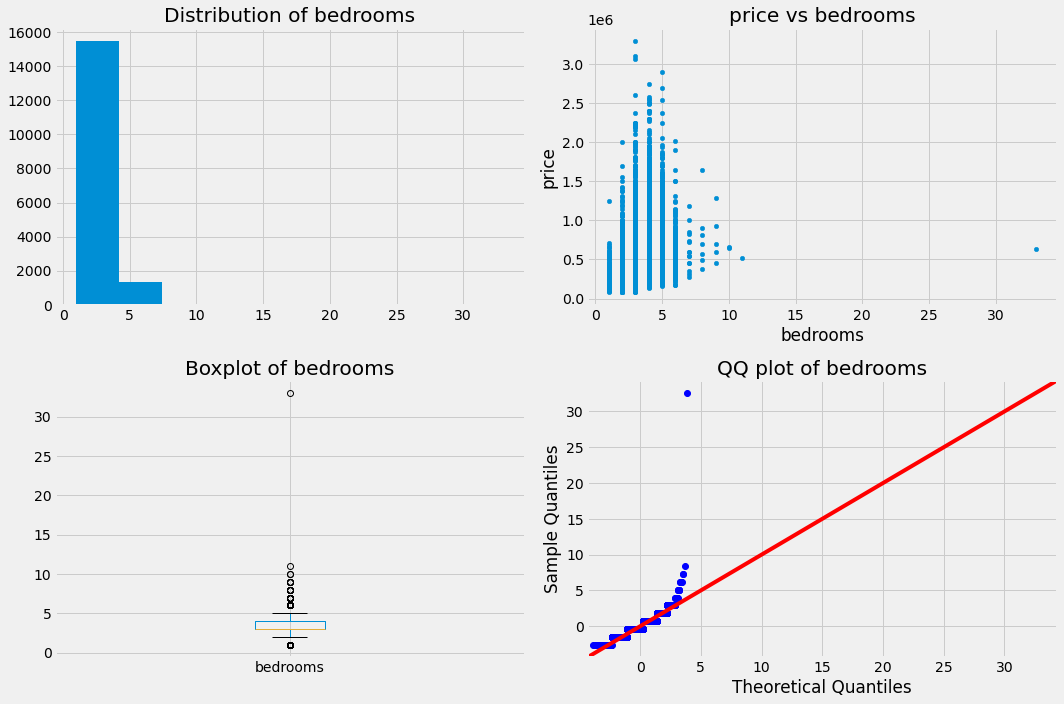

In [1159]:
#look at plots
bedrooms_iqr = get_plots(df_scrub, 'bedrooms',outlier='none')

> **Observations:**
> - 1 particularly large outlier, other outliers beyond 6 bedrooms

> **ACTION:**
> - I will remove outliers based on iqr.

In [1160]:
#remove outliers based off iqr
q25 = df_scrub['bedrooms'].quantile(0.25)
q75 = df_scrub['bedrooms'].quantile(0.75)
iqr = q75-q25
upper_thresh = q75 + 1.5*iqr
lower_thresh = q25 - 1.5*iqr
df_scrub = df_scrub.loc[bedrooms_iqr]
print(f'The number of rows is now {len(df_scrub)}')

The number of rows is now 16431


count             16,431.0
mean        3.327308137058
std     0.7889119312283557
min                    2.0
25%                    3.0
50%                    3.0
75%                    4.0
max                    5.0
Name: bedrooms, dtype: float64


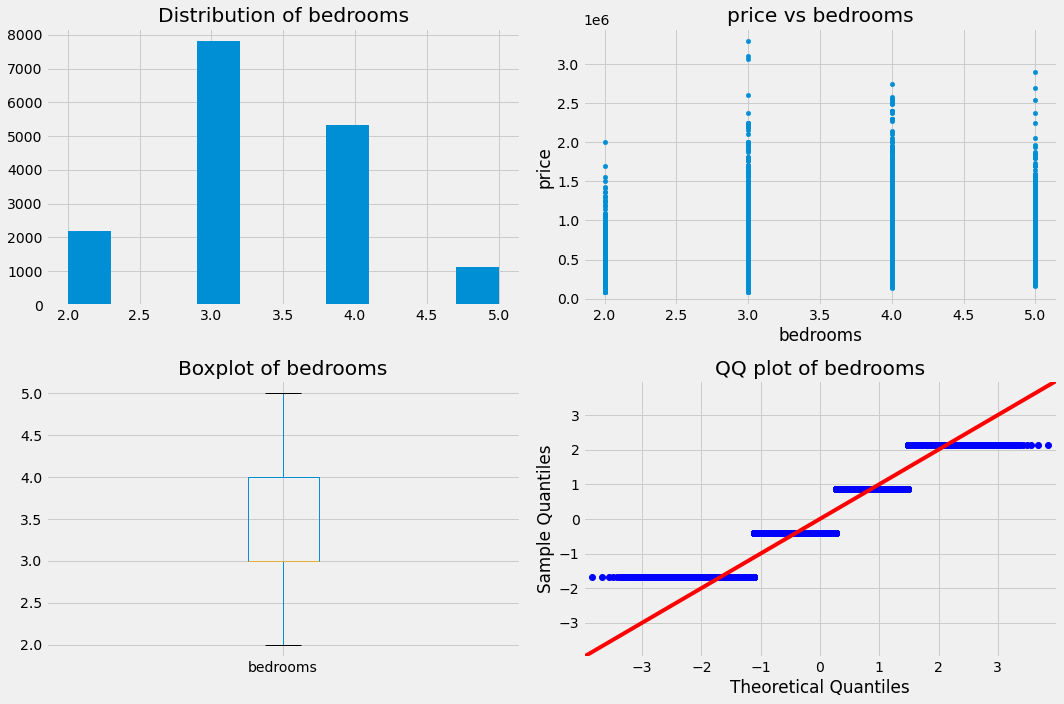

0        True
1        True
3        True
4        True
8        True
         ... 
21592    True
21593    True
21594    True
21595    True
21596    True
Name: bedrooms, Length: 16431, dtype: bool

In [1161]:
#check plots again
get_plots(df_scrub, 'bedrooms',outlier='none')

### `sqft_lot` Column

count              16,431.0
mean    14,447.014058791308
std      40,182.93175790087
min                   520.0
25%                 5,000.0
50%                 7,524.0
75%                10,344.0
max             1,651,359.0
Name: sqft_lot, dtype: float64


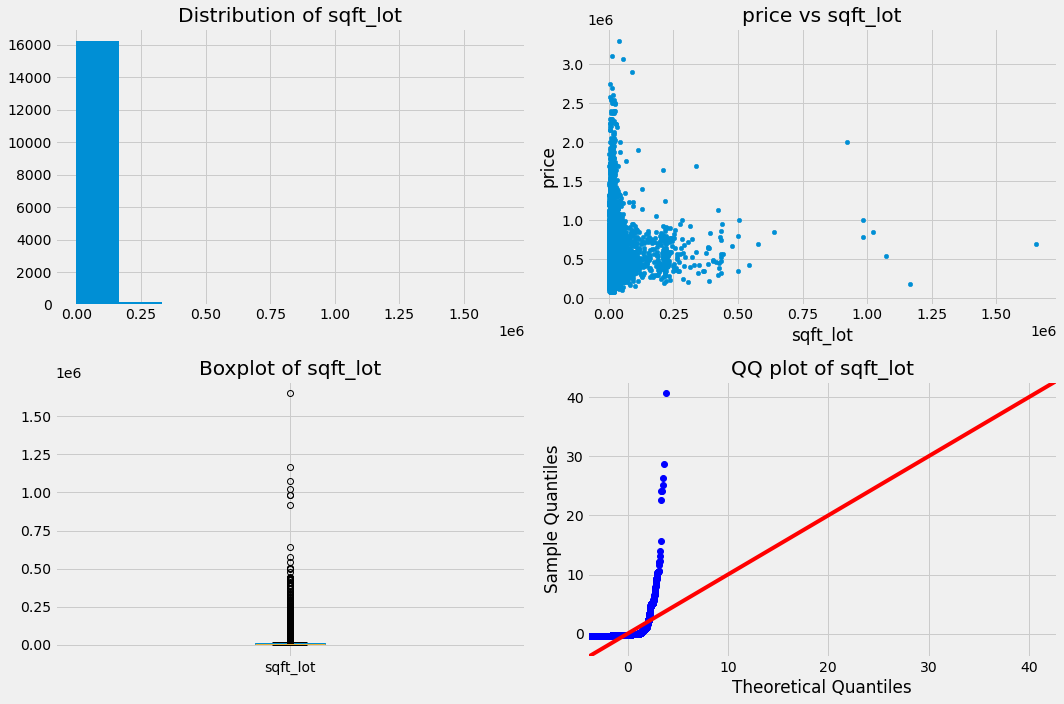

In [1162]:
#check plots
sqft_lot_iqr = get_plots(df_scrub, 'sqft_lot',outlier='none')

> **Observations:**
> - Outliers skewing data

> **ACTION:**
> - Utilize the iqr to remove outliers

In [1163]:
#remove outliers based off iqr
q25 = df_scrub['sqft_lot'].quantile(0.25)
q75 = df_scrub['sqft_lot'].quantile(0.75)
iqr = q75-q25
upper_thresh = q75 + 1.5*iqr
lower_thresh = q25 - 1.5*iqr
df_scrub = df_scrub.loc[sqft_lot_iqr]
print(f'The number of rows is now {len(df_scrub)}')

The number of rows is now 14656


count              14,656.0
mean    7,253.1129912663755
std     3,482.0293504015876
min                   520.0
25%                 4,850.0
50%                 7,200.0
75%                9,241.25
max                18,335.0
Name: sqft_lot, dtype: float64


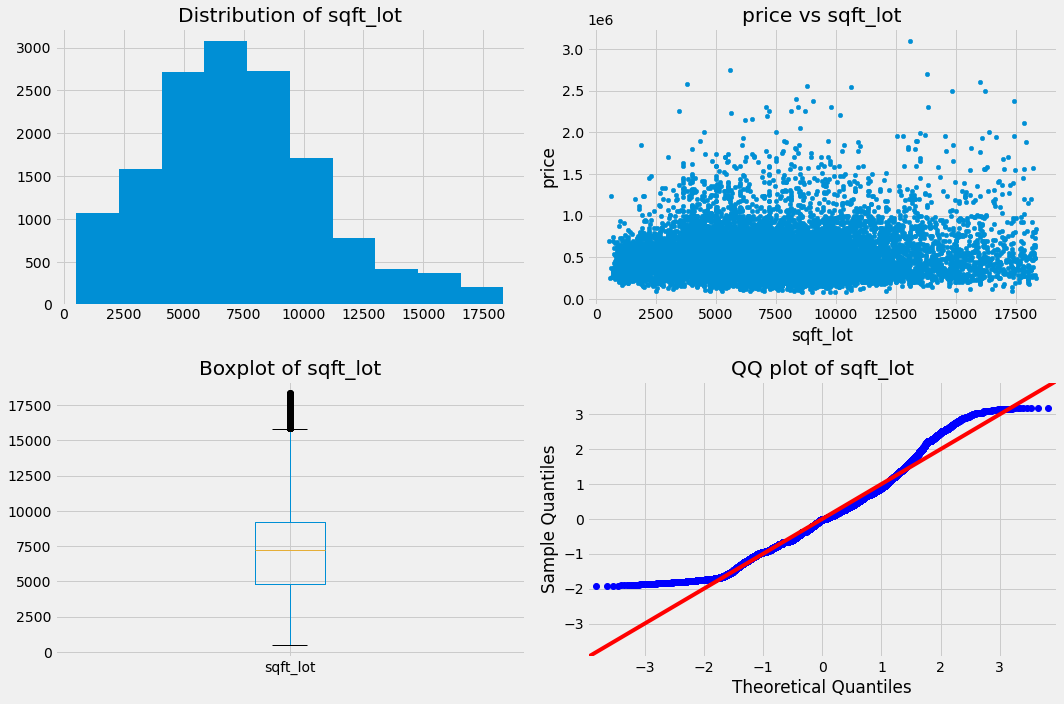

0        True
1        True
3        True
4        True
8        True
         ... 
21592    True
21593    True
21594    True
21595    True
21596    True
Name: sqft_lot, Length: 14656, dtype: bool

In [1164]:
#check the plots
get_plots(df_scrub, 'sqft_lot',outlier='none')

### `home_age` Column

count             14,656.0
mean      43.7551173580786
std     29.924226056777307
min                   -1.0
25%                   16.0
50%                   42.0
75%                   64.0
max                  115.0
Name: home_age, dtype: float64


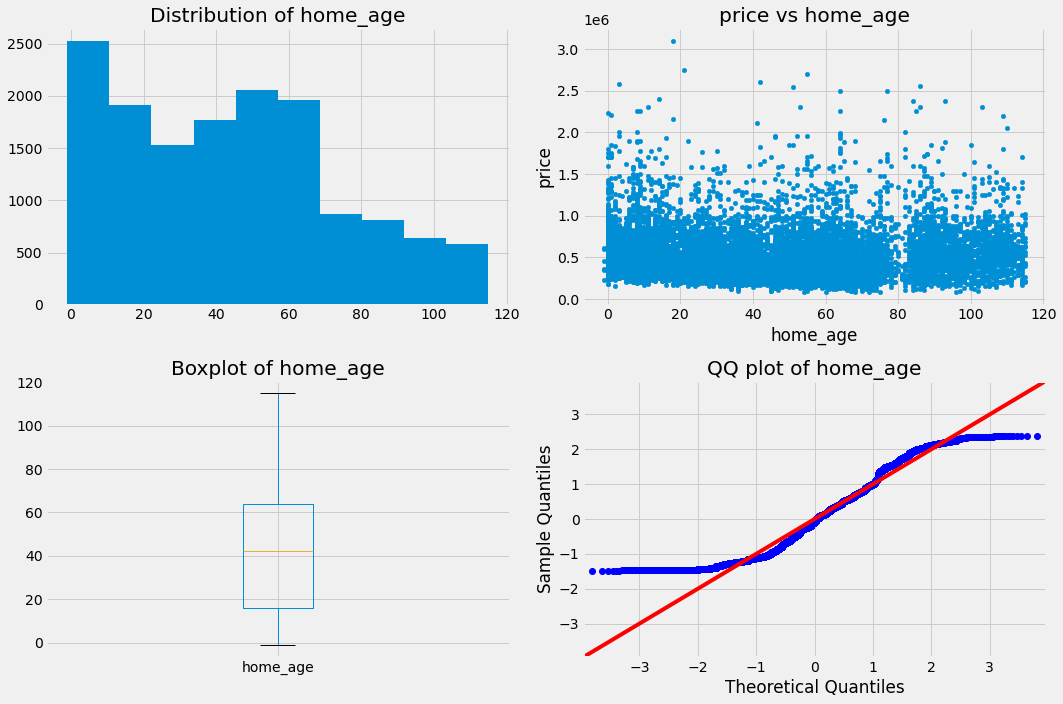

0        True
1        True
3        True
4        True
8        True
         ... 
21592    True
21593    True
21594    True
21595    True
21596    True
Name: home_age, Length: 14656, dtype: bool

In [1165]:
#check the plots
get_plots(df_scrub, 'home_age',outlier='none')

In [1166]:
#view rows with home_age < 0
df_scrub.loc[df_scrub['home_age'] < 0]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,zipcode,lat,long,basement,month_sold,renovated,yr_sold,home_age
7519,9520900210,2014-12-31,"614,285.0",5,2.75,2730,6401,2.0,0.0,0.0,3,8,2730,2015,98072,47.7685,-122.16,0,12,0,2014,-1
17084,9126100346,2014-06-17,"350,000.0",3,2.0,1380,3600,3.0,0.0,0.0,3,8,1380,2015,98122,47.6074,-122.305,0,6,0,2014,-1
19789,9126100765,2014-08-01,"455,000.0",3,1.75,1320,1014,3.0,0.0,0.0,3,9,1320,2015,98122,47.6047,-122.305,0,8,0,2014,-1
20754,9310300160,2014-08-28,"357,000.0",5,2.5,2990,9240,2.0,0.0,0.0,3,8,2990,2015,98133,47.7384,-122.348,0,8,0,2014,-1
20836,1257201420,2014-07-09,"595,000.0",4,3.25,3730,4560,2.0,0.0,0.0,3,9,2760,2015,98103,47.6725,-122.33,1,7,0,2014,-1
20947,6058600220,2014-07-31,"230,000.0",3,1.5,1040,1264,2.0,0.0,0.0,3,9,900,2015,98144,47.5951,-122.301,1,7,0,2014,-1


> **Observations:**
> - There are 5 homes where the sale date is before the yr_built

> **ACTION:**
> - I will remove these homes

In [1167]:
#remove the rows
df_scrub.drop(df_scrub.loc[df_scrub['home_age'] < 0].index, inplace=True)
print(f'The number of rows now is {len(df_scrub)}.')

The number of rows now is 14650.


/Users/brian/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## State of Dataframe

In [1168]:
#state of the dataframe
display(df_scrub.iloc[:10,:20], df_scrub.shape)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,zipcode,lat,long,basement,month_sold,renovated
0,7129300520,2014-10-13,"221,900.0",3,1.0,1180,5650,1.0,0.0,0.0,3,7,1180,1955,98178,47.5112,-122.257,0,10,0
1,6414100192,2014-12-09,"538,000.0",3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,1951,98125,47.721000000000004,-122.319,1,12,1
3,2487200875,2014-12-09,"604,000.0",4,3.0,1960,5000,1.0,0.0,0.0,5,7,1050,1965,98136,47.5208,-122.39299999999999,1,12,0
4,1954400510,2015-02-18,"510,000.0",3,2.0,1680,8080,1.0,0.0,0.0,3,8,1680,1987,98074,47.6168,-122.045,0,2,0
8,2414600126,2015-04-15,"229,500.0",3,1.0,1780,7470,1.0,0.0,0.0,3,7,1050,1960,98146,47.5123,-122.337,1,4,0
9,3793500160,2015-03-12,"323,000.0",3,2.5,1890,6560,2.0,0.0,0.0,3,7,1890,2003,98038,47.3684,-122.031,0,3,0
10,1736800520,2015-04-03,"662,500.0",3,2.5,3560,9796,1.0,0.0,0.0,3,8,1860,1965,98007,47.6007,-122.145,1,4,0
11,9212900260,2014-05-27,"468,000.0",2,1.0,1160,6000,1.0,0.0,0.0,4,7,860,1942,98115,47.69,-122.292,1,5,0
13,6054650070,2014-10-07,"400,000.0",3,1.75,1370,9680,1.0,0.0,0.0,4,7,1370,1977,98074,47.6127,-122.045,0,10,0
14,1175000570,2015-03-12,"530,000.0",5,2.0,1810,4850,1.5,0.0,0.0,3,7,1810,1900,98107,47.67,-122.39399999999999,0,3,0


(14650, 22)

# Explore

I will now explore the dataset after initial scrubbing. I will investigate linearity, multicollinearity and homoscedasticity and correct any issues before modeling.

> **ACTION: I will create a copy of the scrub dataframe to explore the data.**

In [1169]:
#create a copy of the scrub dataframe
df_explore = df_scrub.copy()
df_explore

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,zipcode,lat,long,basement,month_sold,renovated,yr_sold,home_age
0,7129300520,2014-10-13,"221,900.0",3,1.0,1180,5650,1.0,0.0,0.0,3,7,1180,1955,98178,47.5112,-122.257,0,10,0,2014,59
1,6414100192,2014-12-09,"538,000.0",3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,1951,98125,47.721000000000004,-122.319,1,12,1,2014,63
3,2487200875,2014-12-09,"604,000.0",4,3.0,1960,5000,1.0,0.0,0.0,5,7,1050,1965,98136,47.5208,-122.39299999999999,1,12,0,2014,49
4,1954400510,2015-02-18,"510,000.0",3,2.0,1680,8080,1.0,0.0,0.0,3,8,1680,1987,98074,47.6168,-122.045,0,2,0,2015,28
8,2414600126,2015-04-15,"229,500.0",3,1.0,1780,7470,1.0,0.0,0.0,3,7,1050,1960,98146,47.5123,-122.337,1,4,0,2015,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,"360,000.0",3,2.5,1530,1131,3.0,0.0,0.0,3,8,1530,2009,98103,47.6993,-122.346,0,5,0,2014,5
21593,6600060120,2015-02-23,"400,000.0",4,2.5,2310,5813,2.0,0.0,0.0,3,8,2310,2014,98146,47.5107,-122.36200000000001,0,2,0,2015,1
21594,1523300141,2014-06-23,"402,101.0",2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,2009,98144,47.5944,-122.29899999999999,0,6,0,2014,5
21595,291310100,2015-01-16,"400,000.0",3,2.5,1600,2388,2.0,0.0,0.0,3,8,1600,2004,98027,47.5345,-122.069,0,1,0,2015,11


## Linearity

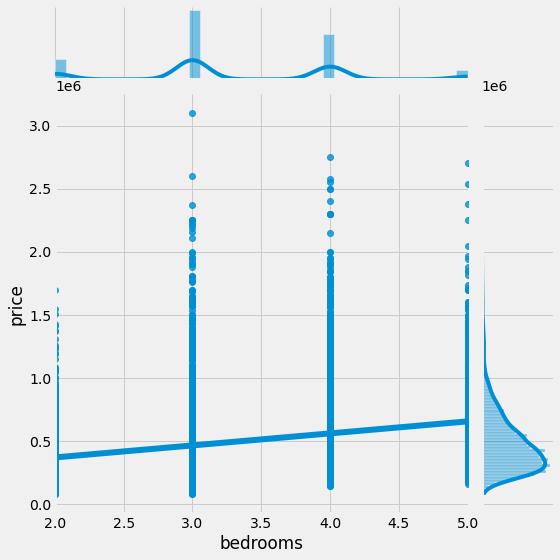

In [1170]:
sns.jointplot(data=df_explore, x='bedrooms', y='price', height=8, kind='reg')

> **Observations:**
> - `sqft_living` shows linearity with `price`
> - `sqft_above` shows linearity with `price`
> - All other columns are non-linear with `price`

## Multicollinearity

I want to check to see if the independent variables are truly independent from each other by checking for multicollinearity.

### Two Variable Multicollinearity Check

In [1171]:
#remove lat and long columns
df_explore.drop(columns=['lat','long'], inplace=True)

<AxesSubplot:>

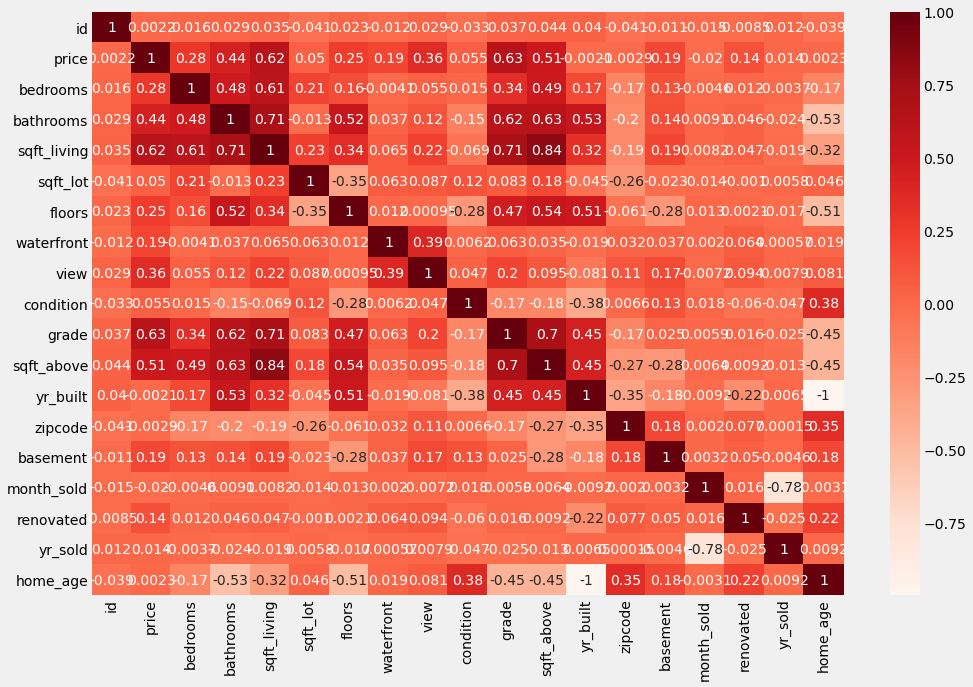

In [1172]:
#create and plot correlations
corr = df_explore.corr()
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corr, cmap='Reds', annot=True, ax=ax)

> **ACTION: Remove `sqft_above` as it correlates very closesly with `sqft_living`**

In [1173]:
#remove sqft_above
df_explore.drop(columns='sqft_above', inplace=True)

<AxesSubplot:>

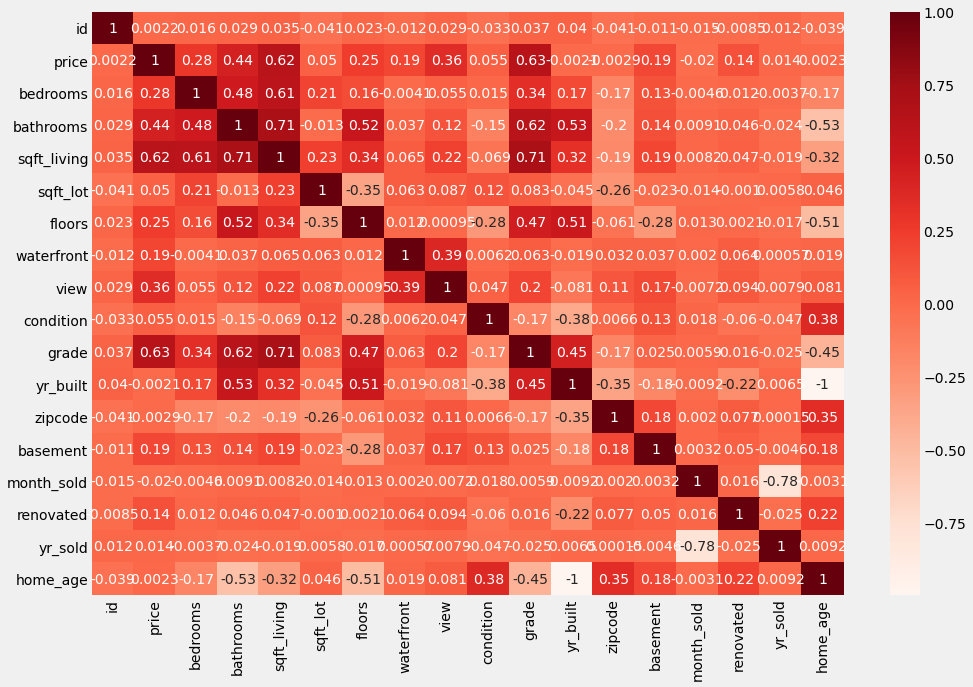

In [1174]:
corr = df_explore.corr()
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corr, cmap='Reds', annot=True, ax=ax)

> **There are no more variables which correlate above .75, therefore, variables are now considered independent.**

## Exploratory Questions

### khg

Home sale price over time

Number of floors and price

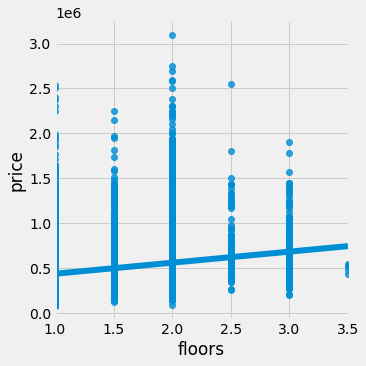

In [1198]:
sns.lmplot(x='floors', y='price', data=df_explore)

average sales price by zipcode

average sales price by month_sold

count              14,650.0
mean      497,249.184778157
std     269,536.08488415787
min                81,000.0
25%               313,100.0
50%               435,000.0
75%               607,000.0
max             3,100,000.0
Name: price, dtype: float64

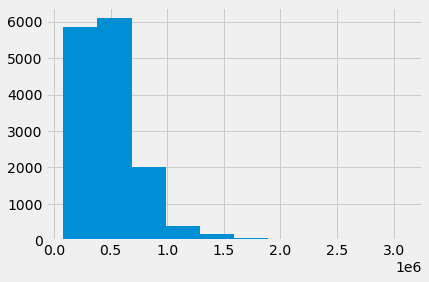

In [1175]:
#distribution of home price
plt.hist(x=df_explore['price'])
df_explore['price'].describe()

# Modeling

In [1176]:
#create a copy of the explore dataframe
df_model_original = df_explore.copy()
df_model_original

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,zipcode,basement,month_sold,renovated,yr_sold,home_age
0,7129300520,2014-10-13,"221,900.0",3,1.0,1180,5650,1.0,0.0,0.0,3,7,1955,98178,0,10,0,2014,59
1,6414100192,2014-12-09,"538,000.0",3,2.25,2570,7242,2.0,0.0,0.0,3,7,1951,98125,1,12,1,2014,63
3,2487200875,2014-12-09,"604,000.0",4,3.0,1960,5000,1.0,0.0,0.0,5,7,1965,98136,1,12,0,2014,49
4,1954400510,2015-02-18,"510,000.0",3,2.0,1680,8080,1.0,0.0,0.0,3,8,1987,98074,0,2,0,2015,28
8,2414600126,2015-04-15,"229,500.0",3,1.0,1780,7470,1.0,0.0,0.0,3,7,1960,98146,1,4,0,2015,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,"360,000.0",3,2.5,1530,1131,3.0,0.0,0.0,3,8,2009,98103,0,5,0,2014,5
21593,6600060120,2015-02-23,"400,000.0",4,2.5,2310,5813,2.0,0.0,0.0,3,8,2014,98146,0,2,0,2015,1
21594,1523300141,2014-06-23,"402,101.0",2,0.75,1020,1350,2.0,0.0,0.0,3,7,2009,98144,0,6,0,2014,5
21595,291310100,2015-01-16,"400,000.0",3,2.5,1600,2388,2.0,0.0,0.0,3,8,2004,98027,0,1,0,2015,11


## Model Preprocessing

### Column Drop

#### `yr_built` Column

I will be removing `yr_built` as it is related to the new column I created named `home_age`

In [1177]:
#drop the yr_built column
df_model_original.drop(columns='yr_built', inplace=True)

#### `id` Column

I will be removing the `id` column as I do not want the model to confuse the meaning of this unique identifier.

In [1178]:
#drop the id column
df_model_original.drop(columns='id', inplace=True)

#### `date` Column

The `date` column represents the sale date which I do not think is relevant to the model's output since it is a datetime object.

In [1179]:
#drop the date column
df_model_original.drop(columns='date', inplace=True)

#### `yr_sold` Column

The `yr_sold` column I created in order to create the `home_age` column. It is no longer needed.

In [1180]:
#drop the yr_sold column
df_model_original.drop(columns='yr_sold', inplace=True)

## Model 1

- The data is now ready for the first model run. So far, I have taken the following steps:
    1. Removed irrelevant columns
    2. Removed some outliers in the raw data
    3. Removed columns due to 2-variable multicollinearity
    

### Model Creation

I will now create the initial model by copying the df_model_original dataframe.

In [1184]:
#create a new model dataframe
df_model_1 = df_model_original.copy()
df_model_1

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,zipcode,basement,month_sold,renovated,home_age
0,"221,900.0",3,1.0,1180,5650,1.0,0.0,0.0,3,7,98178,0,10,0,59
1,"538,000.0",3,2.25,2570,7242,2.0,0.0,0.0,3,7,98125,1,12,1,63
3,"604,000.0",4,3.0,1960,5000,1.0,0.0,0.0,5,7,98136,1,12,0,49
4,"510,000.0",3,2.0,1680,8080,1.0,0.0,0.0,3,8,98074,0,2,0,28
8,"229,500.0",3,1.0,1780,7470,1.0,0.0,0.0,3,7,98146,1,4,0,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,"360,000.0",3,2.5,1530,1131,3.0,0.0,0.0,3,8,98103,0,5,0,5
21593,"400,000.0",4,2.5,2310,5813,2.0,0.0,0.0,3,8,98146,0,2,0,1
21594,"402,101.0",2,0.75,1020,1350,2.0,0.0,0.0,3,7,98144,0,6,0,5
21595,"400,000.0",3,2.5,1600,2388,2.0,0.0,0.0,3,8,98027,0,1,0,11


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,zipcode,basement,month_sold,renovated,home_age
0,"221,900.0",-0.3951250309701679,-1.5118384467601826,-1.048830345788488,-0.46077351695283475,-0.8990049643167043,-0.0763905075459776,-0.27378088976820186,-0.6377977102863774,-0.5319653347943929,1.8025761888020484,-0.7992760295769961,1.0987957817852896,-0.19935342161600594,0.5089660157857367
1,"538,000.0",-0.3951250309701679,0.28359226376483965,0.8613987272973483,-0.003533675000969605,0.9426258442185286,-0.0763905075459776,-0.27378088976820186,-0.6377977102863774,-0.5319653347943929,0.8211036389097945,1.251046826893498,1.738709844441746,5.015874483159864,0.6426708717946136
3,"604,000.0",0.8684815404581144,1.360850690079853,0.023096759971909346,-0.6474606383527797,-0.8990049643167043,-0.0763905075459776,-0.27378088976820186,2.4197076744307133,-0.5319653347943929,1.024805488887432,1.251046826893498,1.738709844441746,-0.19935342161600594,0.1747038757635444
4,"510,000.0",-0.3951250309701679,-0.0754938783401648,-0.36169758568566923,0.2371491061269594,-0.8990049643167043,-0.0763905075459776,-0.27378088976820186,-0.6377977102863774,0.453404769484006,-0.12333221098652525,-0.7992760295769961,-1.4608604688405367,-0.19935342161600594,-0.5272466182830594
8,"229,500.0",-0.3951250309701679,-1.5118384467601826,-0.22427103366510545,0.06195042296701109,-0.8990049643167043,-0.0763905075459776,-0.27378088976820186,-0.6377977102863774,-0.5319653347943929,1.2099889888671027,1.251046826893498,-0.8209464061840802,-0.19935342161600594,0.3752611597768598




                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     1638.
Date:                Tue, 13 Apr 2021   Prob (F-statistic):               0.00
Time:                        23:46:26   Log-Likelihood:            -1.9707e+05
No. Observations:               14650   AIC:                         3.942e+05
Df Residuals:                   14635   BIC:                         3.943e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    4.972e+05   1390.605    357.578    

[('bedrooms', 1.715012594889895),
 ('bathrooms', 3.1045414405494336),
 ('sqft_living', 3.8694376301208973),
 ('sqft_lot', 1.563505399011372),
 ('floors', 2.3742697322022446),
 ('waterfront', 1.1878336351303818),
 ('view', 1.3274144648475925),
 ('condition', 1.2651505673758003),
 ('grade', 2.5129293465263043),
 ('zipcode', 1.3259219029880707),
 ('basement', 1.45604972834047),
 ('month_sold', 1.0015644684010405),
 ('renovated', 1.1405924111052548),
 ('home_age', 2.325218786862967)]



Normality Test Results


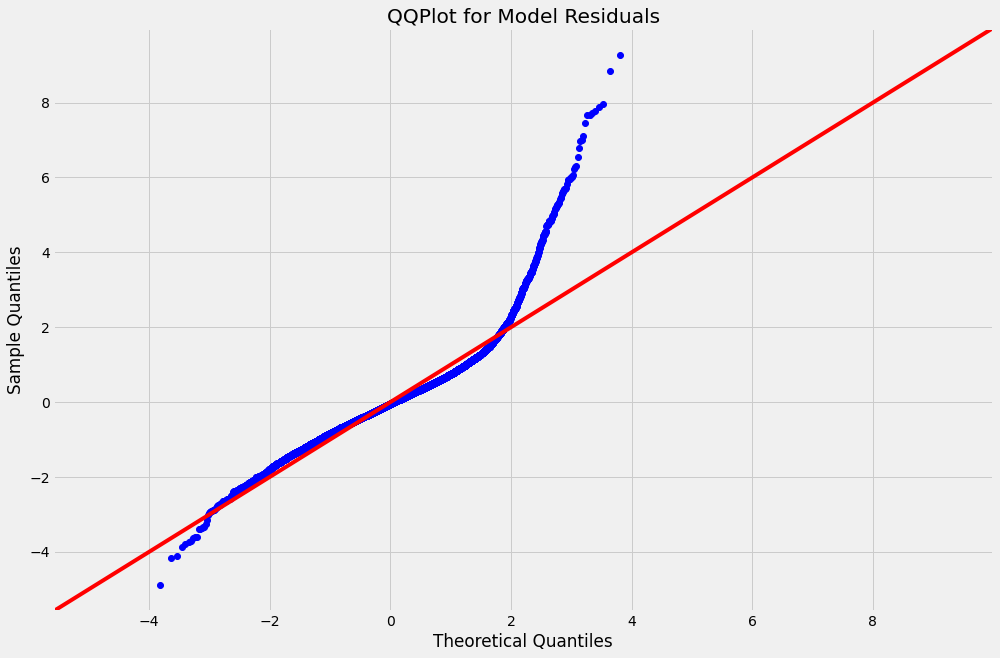



Homoscedasticity Test Results


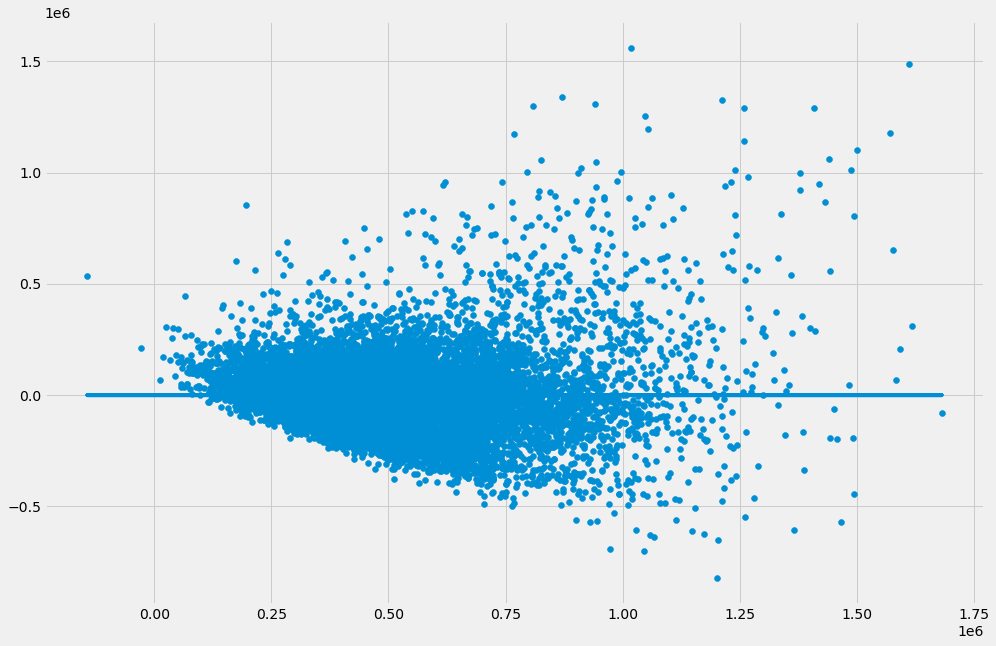

In [1186]:
#define indpendent and dependent variables
x_cols = df_model_1.drop(columns='price').columns
y_col = 'price'
#run funciton to create model and check assumptions
fit_new_model(df_model_1, x_cols=x_cols, y_col=y_col, norm=True)

>**OBSERVATOINS**
> - Adjusted R-Squared of 0.61
> - All features with significant p-values except for `zipcode`
> - The most positively correlated features to price are `sqft_living`, `grade`, `home_age`  and `view`
> - The most negatively correlated features to price are `bedrooms`, `month_sold` and `sqft_lot`
> - No multicollinearity found
> - Residuals not normal on the high end of the distribution
> - I am seeing heteroscedasticity along the bottom edge plus as the price gets higher

> **ACTIONS**
> - I will look at OHE `zipcode`

### Model Tuning

### OHE Columns

I will evaluate `zipcode` for OHE in order to better model this feature.

In [1187]:
#check column names
df_model_1.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'zipcode', 'basement',
       'month_sold', 'renovated', 'home_age'],
      dtype='object')

The number of rows removed is 0
count                 14,650.0
mean    -6.467442432946506e-14
std                        1.0
min        -1.4751717608381203
25%        -0.8825845609031745
50%       -0.12333221098652525
75%         0.6914751889240252
max         2.1914615387593566
Name: zipcode, dtype: float64


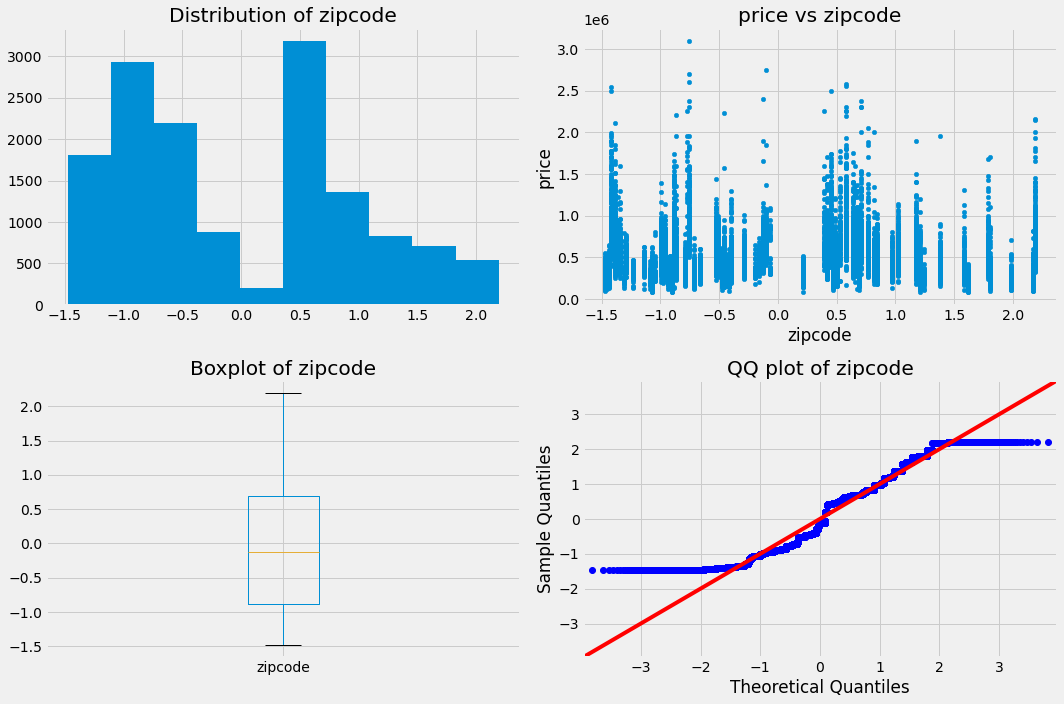

0        True
1        True
3        True
4        True
8        True
         ... 
21592    True
21593    True
21594    True
21595    True
21596    True
Name: zipcode, Length: 14650, dtype: bool

In [1188]:
#investigate zipcode
get_plots(df_model_1,'zipcode')

> **OBSERVATIONS**
> - `zipcode` is categorical and needs to be hot-one encoded to improve the model.

#### `zipcode` OHE

In [1189]:
#fit the data
cat_zipcode = ['zipcode']
encoder = OneHotEncoder(drop='first', sparse=False)
encoder.fit(df_model_original[cat_zipcode])

OneHotEncoder(drop='first', sparse=False)

In [1190]:
#transform the data
ohe_vars = encoder.transform(df_model_original[cat_zipcode])
ohe_vars

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [1191]:
#get the features
encoder.get_feature_names(cat_zipcode)

array(['zipcode_98002', 'zipcode_98003', 'zipcode_98004', 'zipcode_98005',
       'zipcode_98006', 'zipcode_98007', 'zipcode_98008', 'zipcode_98010',
       'zipcode_98011', 'zipcode_98014', 'zipcode_98019', 'zipcode_98022',
       'zipcode_98023', 'zipcode_98024', 'zipcode_98027', 'zipcode_98028',
       'zipcode_98029', 'zipcode_98030', 'zipcode_98031', 'zipcode_98032',
       'zipcode_98033', 'zipcode_98034', 'zipcode_98038', 'zipcode_98039',
       'zipcode_98040', 'zipcode_98042', 'zipcode_98045', 'zipcode_98052',
       'zipcode_98053', 'zipcode_98055', 'zipcode_98056', 'zipcode_98058',
       'zipcode_98059', 'zipcode_98065', 'zipcode_98070', 'zipcode_98072',
       'zipcode_98074', 'zipcode_98075', 'zipcode_98077', 'zipcode_98092',
       'zipcode_98102', 'zipcode_98103', 'zipcode_98105', 'zipcode_98106',
       'zipcode_98107', 'zipcode_98108', 'zipcode_98109', 'zipcode_98112',
       'zipcode_98115', 'zipcode_98116', 'zipcode_98117', 'zipcode_98118',
       'zipcode_98119', '

In [1192]:
#convert to dataframe
df_cat_zipcode = pd.DataFrame(ohe_vars, columns=encoder.get_feature_names(cat_zipcode), index=df_model_original.index)
df_cat_zipcode

,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,...,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21594,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1193]:
#concat original dataframe to zipcode dataframe and prepare for model number 2
df_model_2 = pd.concat([df_model_original.drop('zipcode', axis=1), df_cat_zipcode], axis=1)
df_model_2

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,basement,month_sold,renovated,home_age,zipcode_98002,...,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,"221,900.0",3,1.0,1180,5650,1.0,0.0,0.0,3,7,0,10,0,59,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,"538,000.0",3,2.25,2570,7242,2.0,0.0,0.0,3,7,1,12,1,63,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"604,000.0",4,3.0,1960,5000,1.0,0.0,0.0,5,7,1,12,0,49,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"510,000.0",3,2.0,1680,8080,1.0,0.0,0.0,3,8,0,2,0,28,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,"229,500.0",3,1.0,1780,7470,1.0,0.0,0.0,3,7,1,4,0,55,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,"360,000.0",3,2.5,1530,1131,3.0,0.0,0.0,3,8,0,5,0,5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21593,"400,000.0",4,2.5,2310,5813,2.0,0.0,0.0,3,8,0,2,0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21594,"402,101.0",2,0.75,1020,1350,2.0,0.0,0.0,3,7,0,6,0,5,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21595,"400,000.0",3,2.5,1600,2388,2.0,0.0,0.0,3,8,0,1,0,11,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model 2

Going to refit the model with the new OHE `zipcode` columns

In [1194]:
#view model_2 dataframe
df_model_2.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,basement,month_sold,renovated,home_age,zipcode_98002,...,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,"221,900.0",3,1.0,1180,5650,1.0,0.0,0.0,3,7,0,10,0,59,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,"538,000.0",3,2.25,2570,7242,2.0,0.0,0.0,3,7,1,12,1,63,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"604,000.0",4,3.0,1960,5000,1.0,0.0,0.0,5,7,1,12,0,49,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"510,000.0",3,2.0,1680,8080,1.0,0.0,0.0,3,8,0,2,0,28,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,"229,500.0",3,1.0,1780,7470,1.0,0.0,0.0,3,7,1,4,0,55,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,basement,month_sold,renovated,home_age,zipcode_98002,...,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,"221,900.0",-0.3951250309701679,-1.5118384467601826,-1.048830345788488,-0.46077351695283475,-0.8990049643167043,-0.0763905075459776,-0.27378088976820186,-0.6377977102863774,-0.5319653347943929,-0.7992760295769961,1.0987957817852896,-0.19935342161600594,0.5089660157857367,-0.10306743009920706,...,-0.1458091642037563,-0.1354618843561443,-0.16383935648790965,-0.11734450703848572,-0.13546188435614429,-0.11794086545689547,-0.054884014101599835,-0.1489516565034297,-0.10474530389139662,-0.11152883460127087,-0.10737771239418385,8.456942132921549,-0.08248146272177441,-0.11734450703848572,-0.12877663380703483
1,"538,000.0",-0.3951250309701679,0.28359226376483965,0.8613987272973483,-0.003533675000969605,0.9426258442185286,-0.0763905075459776,-0.27378088976820186,-0.6377977102863774,-0.5319653347943929,1.251046826893498,1.738709844441746,5.015874483159864,0.6426708717946136,-0.10306743009920706,...,6.857811345911096,-0.1354618843561443,-0.16383935648790965,-0.11734450703848572,-0.13546188435614429,-0.11794086545689547,-0.054884014101599835,-0.1489516565034297,-0.10474530389139662,-0.11152883460127087,-0.10737771239418385,-0.1182379783257304,-0.08248146272177441,-0.11734450703848572,-0.12877663380703483
3,"604,000.0",0.8684815404581144,1.360850690079853,0.023096759971909346,-0.6474606383527797,-0.8990049643167043,-0.0763905075459776,-0.27378088976820186,2.4197076744307133,-0.5319653347943929,1.251046826893498,1.738709844441746,-0.19935342161600594,0.1747038757635444,-0.10306743009920706,...,-0.1458091642037563,-0.1354618843561443,-0.16383935648790965,8.521334026196769,-0.13546188435614429,-0.11794086545689547,-0.054884014101599835,-0.1489516565034297,-0.10474530389139662,-0.11152883460127087,-0.10737771239418385,-0.1182379783257304,-0.08248146272177441,-0.11734450703848572,-0.12877663380703483
4,"510,000.0",-0.3951250309701679,-0.0754938783401648,-0.36169758568566923,0.2371491061269594,-0.8990049643167043,-0.0763905075459776,-0.27378088976820186,-0.6377977102863774,0.453404769484006,-0.7992760295769961,-1.4608604688405367,-0.19935342161600594,-0.5272466182830594,-0.10306743009920706,...,-0.1458091642037563,-0.1354618843561443,-0.16383935648790965,-0.11734450703848572,-0.13546188435614429,-0.11794086545689547,-0.054884014101599835,-0.1489516565034297,-0.10474530389139662,-0.11152883460127087,-0.10737771239418385,-0.1182379783257304,-0.08248146272177441,-0.11734450703848572,-0.12877663380703483
8,"229,500.0",-0.3951250309701679,-1.5118384467601826,-0.22427103366510545,0.06195042296701109,-0.8990049643167043,-0.0763905075459776,-0.27378088976820186,-0.6377977102863774,-0.5319653347943929,1.251046826893498,-0.8209464061840802,-0.19935342161600594,0.3752611597768598,-0.10306743009920706,...,-0.1458091642037563,-0.1354618843561443,-0.16383935648790965,-0.11734450703848572,-0.13546188435614429,8.478246591973546,-0.054884014101599835,-0.1489516565034297,-0.10474530389139662,-0.11152883460127087,-0.10737771239418385,-0.1182379783257304,-0.08248146272177441,-0.11734450703848572,-0.12877663380703483




                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     806.7
Date:                Wed, 14 Apr 2021   Prob (F-statistic):               0.00
Time:                        00:01:28   Log-Likelihood:            -1.9144e+05
No. Observations:               14650   AIC:                         3.830e+05
Df Residuals:                   14567   BIC:                         3.837e+05
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      4.972e+05    948.698    524.1

[('bedrooms', 1.771541682966532),
 ('bathrooms', 3.1489579550204465),
 ('sqft_living', 4.144757649193365),
 ('sqft_lot', 2.1062889531623896),
 ('floors', 2.63835333195799),
 ('waterfront', 1.217123405721409),
 ('view', 1.3864992847279816),
 ('condition', 1.334324507292562),
 ('grade', 3.06837133440118),
 ('basement', 1.6588206172830682),
 ('month_sold', 1.007088280728507),
 ('renovated', 1.1609421728775158),
 ('home_age', 3.312859646862798),
 ('zipcode_98002', 1.666118681711196),
 ('zipcode_98003', 1.9266029151971247),
 ('zipcode_98004', 1.7882106620980498),
 ('zipcode_98005', 1.424860422859939),
 ('zipcode_98006', 2.384359252752322),
 ('zipcode_98007', 1.4472119183535577),
 ('zipcode_98008', 1.9254517136527307),
 ('zipcode_98010', 1.1582781298049096),
 ('zipcode_98011', 1.583723246846739),
 ('zipcode_98014', 1.1554293850623925),
 ('zipcode_98019', 1.4354182787950605),
 ('zipcode_98022', 1.4766981726587458),
 ('zipcode_98023', 2.5704062647120343),
 ('zipcode_98024', 1.0969133488895817)



Normality Test Results


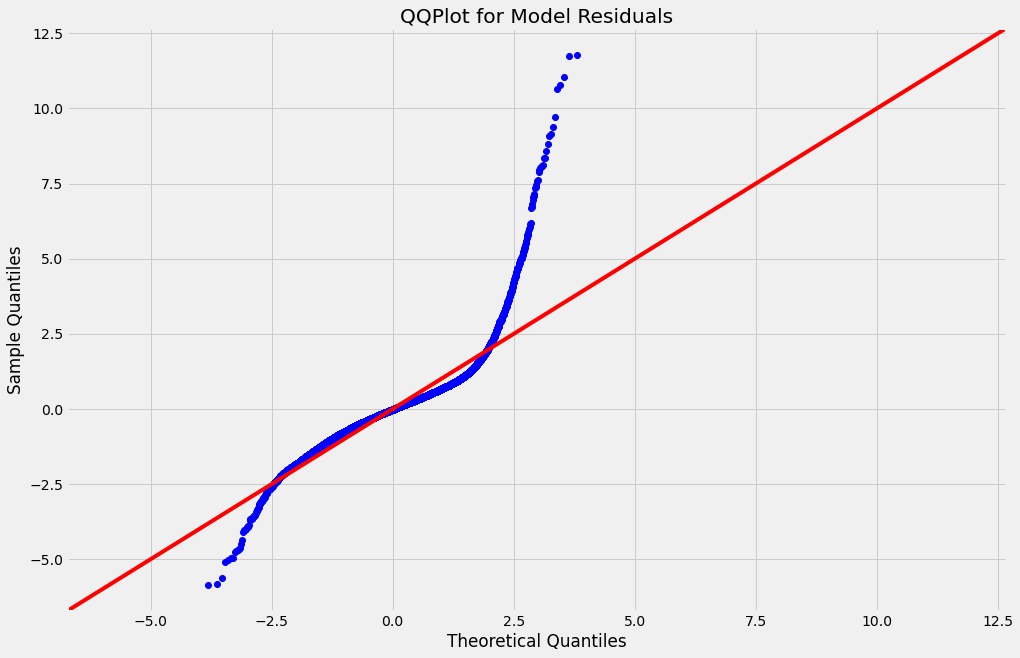



Homoscedasticity Test Results


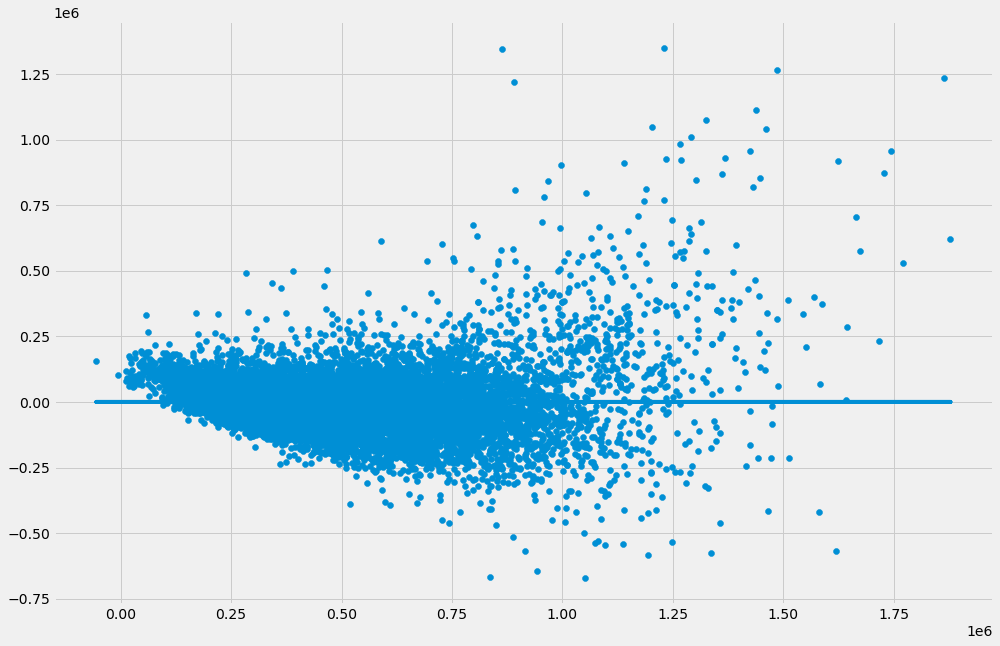

In [1195]:
#define indpendent and dependent variables
x_cols = df_model_2.drop(columns='price').columns
y_col = 'price'
#run funciton to create model and check assumptions
fit_new_model(df_model_2, x_cols=x_cols, y_col=y_col, norm=True)

>**OBSERVATOINS**
> - Adjusted R-Squared of 0.819
> - All features with significant p-values except for some zipcodes 
> - The most positively correlated features to price are `sqft_living`, `grade`  and `view`
> - The most negatively correlated features to price are `bedrooms` and `month_sold`

### Normalization

In [2782]:
#duplicate the dataframe for normalization
df_model_2_norm = df_model_2.copy()

In [2783]:
#set the independent and dependent columns
outcome = 'price'
predictors = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'waterfront',
          'view', 'condition', 'grade', 'basement', 'month_sold', 
          'renovated', 'home_age']

In [2784]:
#normalize the data
for col in predictors:
    df_model_2_norm[col] = (df_model_2_norm[col] - df_model_2_norm[col].mean())/df_model_2_norm[col].std()
df_model_2_norm.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,view,condition,grade,zipcode,basement,month_sold,renovated,home_age
0,"221,900.0",-0.3701707722239618,-1.5055157333639446,-1.0389500841401678,-0.4490044556388432,-0.05536316582717804,-0.2475261349484418,-0.6342435570078807,-0.4928945894453054,98178,-0.7817936198021577,1.097245720853994,-0.18852995483006196,0.5144306876976776
1,"538,000.0",-0.3701707722239618,0.3420110744855665,0.9901885669265627,0.012772618961704335,-0.05536316582717804,-0.2475261349484418,-0.6342435570078807,-0.4928945894453054,98125,1.2790190486572204,1.7371257191189733,5.303819930084642,0.6490313460820359
3,"604,000.0",0.9030320965033336,1.4505271591952733,0.09970325962389674,-0.6375440903689663,-0.05536316582717804,-0.2475261349484418,2.445273727553158,-0.4928945894453054,98136,1.2790190486572204,1.7371257191189733,-0.18852995483006196,0.1779290417367818
4,"510,000.0",-0.3701707722239618,-0.027494287084335718,-0.3090440945478187,0.25584371727530913,-0.05536316582717804,-0.2475261349484418,-0.6342435570078807,0.5600156531666407,98074,-0.7817936198021577,-1.4622742722059228,-0.18852995483006196,-0.5287244147810994
8,"229,500.0",-0.3701707722239618,-1.5055157333639446,-0.16306289662934892,0.07890652160550135,-0.05536316582717804,-0.2475261349484418,-0.6342435570078807,-0.4928945894453054,98146,1.2790190486572204,-0.8223942739409434,-0.18852995483006196,0.37983002931331933


### OHE Columns

#### `zipcode` OHE

In [2787]:
#fit the data
cat_zipcode = ['zipcode']
encoder = OneHotEncoder(drop='first', sparse=False)
encoder.fit(df_model_2_norm[cat_zipcode])

OneHotEncoder(drop='first', sparse=False)

In [2788]:
#transform the data
ohe_vars = encoder.transform(df_model_2_norm[cat_zipcode])
ohe_vars

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [2789]:
#get the features
encoder.get_feature_names(cat_zipcode)

array(['zipcode_98002', 'zipcode_98003', 'zipcode_98004', 'zipcode_98005',
       'zipcode_98006', 'zipcode_98007', 'zipcode_98008', 'zipcode_98010',
       'zipcode_98011', 'zipcode_98014', 'zipcode_98019', 'zipcode_98022',
       'zipcode_98023', 'zipcode_98024', 'zipcode_98027', 'zipcode_98028',
       'zipcode_98029', 'zipcode_98030', 'zipcode_98031', 'zipcode_98032',
       'zipcode_98033', 'zipcode_98034', 'zipcode_98038', 'zipcode_98039',
       'zipcode_98040', 'zipcode_98042', 'zipcode_98045', 'zipcode_98052',
       'zipcode_98053', 'zipcode_98055', 'zipcode_98056', 'zipcode_98058',
       'zipcode_98059', 'zipcode_98065', 'zipcode_98070', 'zipcode_98072',
       'zipcode_98074', 'zipcode_98075', 'zipcode_98077', 'zipcode_98092',
       'zipcode_98102', 'zipcode_98103', 'zipcode_98105', 'zipcode_98106',
       'zipcode_98107', 'zipcode_98108', 'zipcode_98109', 'zipcode_98112',
       'zipcode_98115', 'zipcode_98116', 'zipcode_98117', 'zipcode_98118',
       'zipcode_98119', '

In [2790]:
#convert to dataframe
df_cat_zipcode = pd.DataFrame(ohe_vars, columns=encoder.get_feature_names(cat_zipcode), index=df_model_2_norm.index)
df_cat_zipcode

,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,...,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21594,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2791]:
#concat original dataframe to zipcode dataframe
df_model_2_norm = pd.concat([df_model_2_norm.drop('zipcode', axis=1), df_cat_zipcode], axis=1)
df_model_2_norm

,price,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,view,condition,grade,basement,month_sold,renovated,...,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,"221,900.0",-0.3701707722239618,-1.5055157333639446,-1.0389500841401678,-0.4490044556388432,-0.05536316582717804,-0.2475261349484418,-0.6342435570078807,-0.4928945894453054,-0.7817936198021577,1.097245720853994,-0.18852995483006196,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,"538,000.0",-0.3701707722239618,0.3420110744855665,0.9901885669265627,0.012772618961704335,-0.05536316582717804,-0.2475261349484418,-0.6342435570078807,-0.4928945894453054,1.2790190486572204,1.7371257191189733,5.303819930084642,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"604,000.0",0.9030320965033336,1.4505271591952733,0.09970325962389674,-0.6375440903689663,-0.05536316582717804,-0.2475261349484418,2.445273727553158,-0.4928945894453054,1.2790190486572204,1.7371257191189733,-0.18852995483006196,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"510,000.0",-0.3701707722239618,-0.027494287084335718,-0.3090440945478187,0.25584371727530913,-0.05536316582717804,-0.2475261349484418,-0.6342435570078807,0.5600156531666407,-0.7817936198021577,-1.4622742722059228,-0.18852995483006196,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,"229,500.0",-0.3701707722239618,-1.5055157333639446,-0.16306289662934892,0.07890652160550135,-0.05536316582717804,-0.2475261349484418,-0.6342435570078807,-0.4928945894453054,1.2790190486572204,-0.8223942739409434,-0.18852995483006196,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,"360,000.0",-0.3701707722239618,0.7115164360554688,-0.5280158914255234,-1.7597900084779603,-0.05536316582717804,-0.2475261349484418,-0.6342435570078807,0.5600156531666407,-0.7817936198021577,-0.5024542748084538,-0.18852995483006196,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21593,"400,000.0",0.9030320965033336,0.7115164360554688,0.610637452338541,-0.4017245164680585,-0.05536316582717804,-0.2475261349484418,-0.6342435570078807,0.5600156531666407,-0.7817936198021577,-1.4622742722059228,-0.18852995483006196,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21594,"402,101.0",-1.6433736409512572,-1.8750210949338468,-1.2725200008097195,-1.6962666546227343,-0.05536316582717804,-0.2475261349484418,-0.6342435570078807,-0.4928945894453054,-0.7817936198021577,-0.18251427567596426,-0.18852995483006196,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21595,"400,000.0",-0.3701707722239618,0.7115164360554688,-0.4258290528825946,-1.395183361007553,-0.05536316582717804,-0.2475261349484418,-0.6342435570078807,0.5600156531666407,-0.7817936198021577,-1.7822142713384124,-0.18852995483006196,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Model Creation

In [2792]:
#view the dataframe
df_model_2_norm

,price,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,view,condition,grade,basement,month_sold,renovated,...,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,"221,900.0",-0.3701707722239618,-1.5055157333639446,-1.0389500841401678,-0.4490044556388432,-0.05536316582717804,-0.2475261349484418,-0.6342435570078807,-0.4928945894453054,-0.7817936198021577,1.097245720853994,-0.18852995483006196,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,"538,000.0",-0.3701707722239618,0.3420110744855665,0.9901885669265627,0.012772618961704335,-0.05536316582717804,-0.2475261349484418,-0.6342435570078807,-0.4928945894453054,1.2790190486572204,1.7371257191189733,5.303819930084642,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"604,000.0",0.9030320965033336,1.4505271591952733,0.09970325962389674,-0.6375440903689663,-0.05536316582717804,-0.2475261349484418,2.445273727553158,-0.4928945894453054,1.2790190486572204,1.7371257191189733,-0.18852995483006196,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"510,000.0",-0.3701707722239618,-0.027494287084335718,-0.3090440945478187,0.25584371727530913,-0.05536316582717804,-0.2475261349484418,-0.6342435570078807,0.5600156531666407,-0.7817936198021577,-1.4622742722059228,-0.18852995483006196,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,"229,500.0",-0.3701707722239618,-1.5055157333639446,-0.16306289662934892,0.07890652160550135,-0.05536316582717804,-0.2475261349484418,-0.6342435570078807,-0.4928945894453054,1.2790190486572204,-0.8223942739409434,-0.18852995483006196,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,"360,000.0",-0.3701707722239618,0.7115164360554688,-0.5280158914255234,-1.7597900084779603,-0.05536316582717804,-0.2475261349484418,-0.6342435570078807,0.5600156531666407,-0.7817936198021577,-0.5024542748084538,-0.18852995483006196,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21593,"400,000.0",0.9030320965033336,0.7115164360554688,0.610637452338541,-0.4017245164680585,-0.05536316582717804,-0.2475261349484418,-0.6342435570078807,0.5600156531666407,-0.7817936198021577,-1.4622742722059228,-0.18852995483006196,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21594,"402,101.0",-1.6433736409512572,-1.8750210949338468,-1.2725200008097195,-1.6962666546227343,-0.05536316582717804,-0.2475261349484418,-0.6342435570078807,-0.4928945894453054,-0.7817936198021577,-0.18251427567596426,-0.18852995483006196,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21595,"400,000.0",-0.3701707722239618,0.7115164360554688,-0.4258290528825946,-1.395183361007553,-0.05536316582717804,-0.2475261349484418,-0.6342435570078807,0.5600156531666407,-0.7817936198021577,-1.7822142713384124,-0.18852995483006196,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2793]:
#set up model parameters
outcome = 'price'
predictors = df_model_2_norm.drop(outcome, axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum

In [2794]:
predictors_int = sm.add_constant(predictors)
model_2 = sm.OLS(df_model_2['price'],predictors_int).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     889.3
Date:                Tue, 13 Apr 2021   Prob (F-statistic):               0.00
Time:                        16:32:25   Log-Likelihood:            -1.7859e+05
No. Observations:               14071   AIC:                         3.573e+05
Df Residuals:                   13989   BIC:                         3.580e+05
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.898e+05   5280.600     54.889      0.000    2.79e+05       3e+05
bedrooms      -3227.7415    886.620     -3.641      0.000   -4965.634   -1489.849
bathrooms      7903.0111   1133.789      6.970      0.000    5680.634    1.01e+04
sqft_living    7.965e+04   1290.538     61.715      0.000    7.71e+04    8.22e+04
sqft_lot       5800.1213    924.616      6.273      0.000    3987.750    7612.492
waterfront     3745.9502    717.824      5.218      0.000    2338.918    5152.982
view           1.922e+04    745.524     25.782      0.000    1.78e+04    2.07e+04
condition       1.32e+04    765.646     17.247      0.000    1.17e+04    1.47e+04
grade           4.62e+04   1112.096     41.543      0.000     4.4e+04    4.84e+04
basement      -9918.6713    762.981    -13.000      0.000   -1.14e+04   -8423.127
month_sold    -7568.6101    667.886    -11.332      0.000   -8877.756   -6259.464
renovated      5261.5662    709.956      7.411      0.000    3869.958    6653.175
home_age       1.766e+04   1179.642     14.973      0.000    1.54e+04       2e+04
zipcode_98002  1.011e+04   8255.508      1.224      0.221   -6073.932    2.63e+04
zipcode_98003 -1044.6724   7476.072     -0.140      0.889   -1.57e+04    1.36e+04
zipcode_98004   5.09e+05   9262.919     54.950      0.000    4.91e+05    5.27e+05
zipcode_98005   3.36e+05   9845.593     34.127      0.000    3.17e+05    3.55e+05
zipcode_98006  2.728e+05   7115.298     38.339      0.000    2.59e+05    2.87e+05
zipcode_98007   2.44e+05   9500.944     25.686      0.000    2.25e+05    2.63e+05
zipcode_98008  2.372e+05   7604.132     31.191      0.000    2.22e+05    2.52e+05
zipcode_98010  9.241e+04   1.42e+04      6.521      0.000    6.46e+04     1.2e+05
zipcode_98011  1.485e+05   8558.656     17.353      0.000    1.32e+05    1.65e+05
zipcode_98014  1.043e+05   1.44e+04      7.268      0.000    7.62e+04    1.32e+05
zipcode_98019  9.409e+04   9439.547      9.967      0.000    7.56e+04    1.13e+05
zipcode_98022  -722.3908   9181.337     -0.079      0.937   -1.87e+04    1.73e+04
zipcode_98023 -1.605e+04   6637.174     -2.419      0.016   -2.91e+04   -3042.891
zipcode_98024  1.247e+05   1.76e+04      7.073      0.000    9.02e+04    1.59e+05
zipcode_98027  2.405e+05   7802.486     30.820      0.000    2.25e+05    2.56e+05
zipcode_98028  1.327e+05   7596.314     17.466      0.000    1.18e+05    1.48e+05
zipcode_98029  2.346e+05   7387.129     31.760      0.000     2.2e+05    2.49e+05
zipcode_98030  6713.9911   7811.387      0.860      0.390   -8597.370     2.2e+04
zipcode_98031  1.345e+04   7671.818      1.754      0.079   -1583.169    2.85e+04
zipcode_98032 -4258.9657   9581.997     -0.444      0.657    -2.3e+04    1.45e+04
zipcode_98033  3.132e+05   7092.546     44.158      0.000    2.99e+05    3.27e+05
zipcode_98034  1.915e+05   6555.603     29.212   

>**OBSERVATIONS**
> - Adjusted R-Squared is now 0.836
> - All features with a significant p-value except for some zipcodes
> - Majority of zipcodes with significant p-values so I will keep them in
> - Coefficients of features are smaller in absolute than they were in model 1. I believe this is because of removing outliers in pricing

### Model Tuning

### Homoscedasticity

In [ ]:
plt.scatter(model.predict(df[x_cols]), model.resid)
plt.plot(model.predict(df[x_cols]), [0 for i in range(len(df))])

> **OBSERVATIONS**
> - Model residuals are not normal toward tails of the distributions

>**ACTIONS**
> - I will examine outliers in `price` to see how that will improve the model.

count             14,650.0
mean     497,249.184778157
std     269,536.0848841574
min               81,000.0
25%              313,100.0
50%              435,000.0
75%              607,000.0
max            3,100,000.0
Name: price, dtype: float64


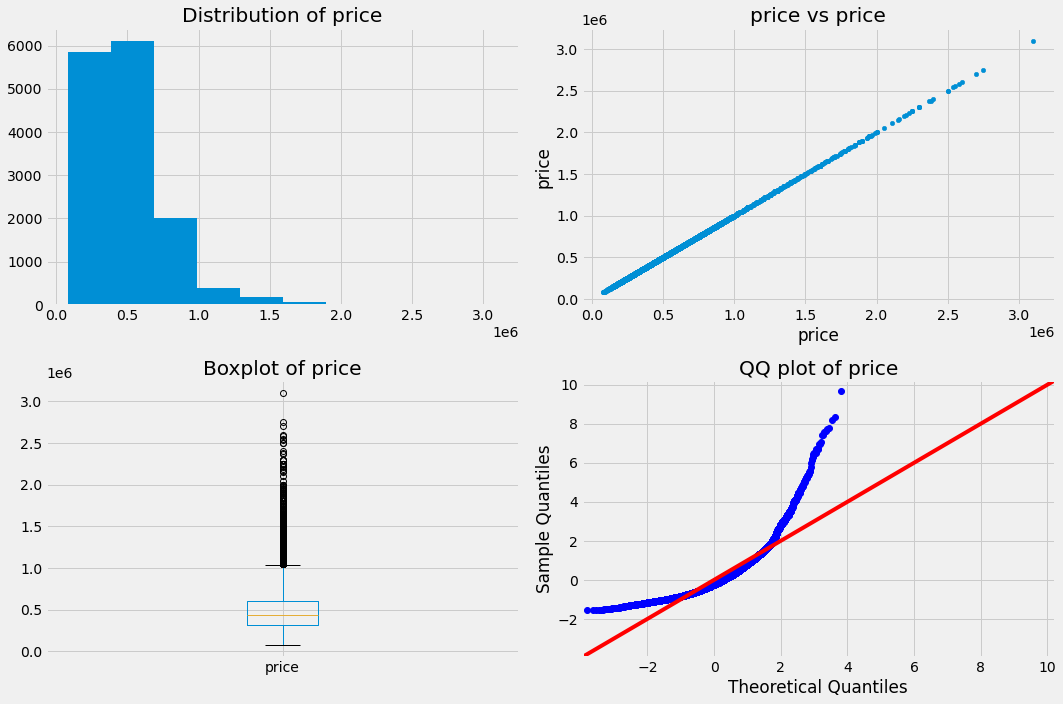

In [2777]:
price_iqr = get_plots(df_model_1,'price',outlier='none')

> **OBSERVATIONS**
> - I will use iqr to remove outliers because there are a lot of outliers on the high side of `price`. This will be done in the **Outlier Removal** section.

In [2776]:
#create a copy of model_1 to set up model_2
df_model_2 = df_model_1.copy()
df_model_2

,price,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,view,condition,grade,zipcode,basement,month_sold,renovated,home_age
0,"221,900.0",3,1.0,1180,5650,0.0,0.0,3,7,98178,0,10,0,59
1,"538,000.0",3,2.25,2570,7242,0.0,0.0,3,7,98125,1,12,1,63
3,"604,000.0",4,3.0,1960,5000,0.0,0.0,5,7,98136,1,12,0,49
4,"510,000.0",3,2.0,1680,8080,0.0,0.0,3,8,98074,0,2,0,28
8,"229,500.0",3,1.0,1780,7470,0.0,0.0,3,7,98146,1,4,0,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,"360,000.0",3,2.5,1530,1131,0.0,0.0,3,8,98103,0,5,0,5
21593,"400,000.0",4,2.5,2310,5813,0.0,0.0,3,8,98146,0,2,0,1
21594,"402,101.0",2,0.75,1020,1350,0.0,0.0,3,7,98144,0,6,0,5
21595,"400,000.0",3,2.5,1600,2388,0.0,0.0,3,8,98027,0,1,0,11


In [2779]:
#remove outliers based off iqr
q25 = df_model_2['price'].quantile(0.25)
q75 = df_model_2['price'].quantile(0.75)
iqr = q75-q25
upper_thresh = q75 + 1.5*iqr
lower_thresh = q25 - 1.5*iqr
df_model_2 = df_model_2.loc[price_iqr]
print(f'The number of rows is now {len(df_model_2)}')

The number of rows is now 14071


count              14,071.0
mean     460,950.9314902992
std     195,142.40378965315
min                81,000.0
25%               309,000.0
50%               425,000.0
75%               579,975.0
max             1,040,000.0
Name: price, dtype: float64


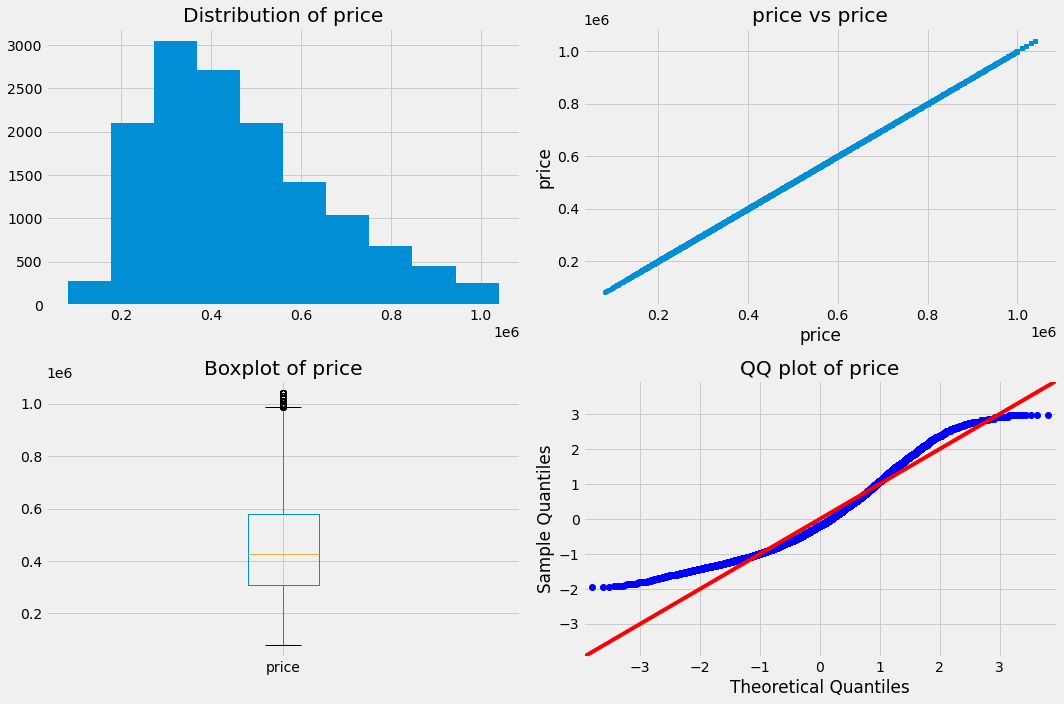

0        True
1        True
3        True
4        True
8        True
         ... 
21592    True
21593    True
21594    True
21595    True
21596    True
Name: price, Length: 14071, dtype: bool

In [2780]:
#recheck the price column
get_plots(df_model_2,'price',outlier='none')